# 서약
* 당연한 것을 아래와 같이 한번 다지고 가도록 하겠습니다. 아래 보고서는 **본인의 힘만으로 작성**해야하며, 다른 수강생에게 직접적인 질문, 복사 하는 행위는 모두 금지합니다 
  * 예를 들어서, 본 프로젝트의 코드 셀을 완성하는데 직접적인 질문 또는 복사하는 경우는 모두 금지합니다
  * 수업에서 제공한 코드, 노트북은 모두 재활용가능하며, 카피로 규정하지 않습니다
  * 수업 자료 이외에 참고자료가 있다면, 출처와 사용 부분에 모두 표시하는 경우는 모두 합당한 자료로 인정하겠습니다
  
* 위에 대해서 모두 이해하고 동의했다면, 아래 `서약글`에 다음을 작성해주세요:

"본인은 위 서약글을 이해하고 동의하며, 프로젝트를 수행하는데 있어서 반칙을 할 경우 (제공자 포함) 본 프로젝트에 대한 점수가 반영되지 않는다는 것에 동의 합니다."

**서약서**

이름: 신유승

학번: 20155326

서약글:  본인은 위 서약글을 이해하고 동의하며, 프로젝트를 수행하는데 있어서 반칙을 할 경우(제공자 포함)본 프로젝트에 대한 점수가 반영되지 않는다는 것에 동의합니다.

# Final Project 

## Project: 새 품종 분류하기

## Due date: 2021.06.15

---

* 아래 여러 셀에서 코드를 완성하는 부분을 수행하고, 설명을 요구하는 부분은 보고서에 설명을 최대한 자세하게 적어주세요. 기준은 본인이 이해하고 있다는 것을 표현할 수 있는 부분을 모두 적으시면 됩니다.
  * 답을 작성하는 원칙은 **보고서**를 작성한다고 생각하시면 됩니다
  * 내가 알고 있는 부분을 충실하게 **글로 표현** 하는 것 또한 중요한 연습입니다 
  * 코드 작성은 **주석**으로 설명하시기 바랍니다
  
  
> **제출방법**: 
* 보고서에는 코드 캡쳐 첨부이외에도, 각 코드를 작성하는 방법론과 설명을 작성해야하는 **서술형 문제**도 포함되어 있습니다.
* 서술형 문제는 채점하는 중요한 기준이 됩니다. 성실하게 작성해주세요.
* 서술형 문제에 대한 답변은 첨부된 보고서에 작성하면 됩니다. 


### 목표: 앱을 위한 인공지능 알고리즘 개발 ^ㅡ^
* 본 보고서에서는 모바일/웹앱을 위한 인공지능 알고리즘을 개발하라는 업무를 부여받았다고 가정합니다
* 프로젝트가 완성본은, 사용자가 제공하는 image를 받아서 새의 종(種)을 예측합니다


---

## Step 0: Import library

- 필요하다 생각되는 라이브러리를 미리 import해 놓은 항목입니다.(참고)
- 필요 없는 라이브러리를 제거하거나 필요한 라이브러리를 추가하셔도 됩니다.

In [1]:
import shutil
import os
import glob
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd

from pathlib import Path
from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# Test for Cuda (Cuda 환경에서 적용되는지 확인)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
#train_on_gpu = False

if not train_on_gpu:
    device = 'cpu'
    print('CUDA is not available.  Training on CPU ...')
else:
    device = 'cuda'
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Step 1: Dataset 준비하기

In [6]:
# 이미지 리사이즈 및 정규화
# train data transforms 적용 (랜덤기울이기, 색상 조절, 랜덤원근법, 랜덤회전, 랜덤수평뒤집기, 이미지 리사이즈, torch텐서로 전환, 데이터 정규화)
transform_train = transforms.Compose([
    #transforms.Resize((128, 128)),
    transforms.RandomAffine(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# validation data transforms 적용 (100사이즈 기준 랜덤자르기, 이미지 리사이즈, torch텐서로 전환, 데이터 정규화)
transform_val = transforms.Compose([
    #transforms.RandomCrop(100),
    transforms.RandomRotation(30, center=(0,0), expand=True),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# test data transforms 적용 (이미지 리사이즈, torch텐서로 전환, 데이터 정규화)
transform_test = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])


# dataset 이미지 경로 할당
train_dir = "./imgs/train"

# ImageFolder를 통해 transform 적용된 이미지 불러오기
train_data = torchvision.datasets.ImageFolder(root=train_dir,transform=transform_train)
valid_data = torchvision.datasets.ImageFolder(root=train_dir,transform=transform_val)


# train data 클래스 저장
class_names = train_data.classes

# train과 validation 데이터 transform 적용을 다르게 하기 위해 따로 분리 적용
# train data 길이 저장
num_train = len(train_data)
# train data 길이만큼 리스트 저장
indices = list(range(num_train))
# train data 와 valid data 분리를 위해 8:2(train:valid) 비율로 데이터 분할
split = int(np.floor(0.2*num_train))

# 데이터 셔플을 위한 저장된 리스트 indices 셔플
np.random.shuffle(indices)

## Step 2: Dataset 에 대한 Data Loaders 구성

In [7]:
# split을 기준으로 triain_idx, valid_idx 분할
train_idx, valid_idx = indices[split:], indices[:split]

# epoch마다 데이터를 섞어 각 train_sampler, valid_sampler에 저장
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# 빈 딕셔너리 dataloader 생성
dataloaders = {}
# dataloader를 통한 train데이터 불러오기 (배치사이즈 : 64, 현재 환경에서 프로세스 num_workers를 4로 설정)
dataloaders["train"] = torch.utils.data.DataLoader(train_data,
                                                   batch_size=32,
                                                   sampler=train_sampler,
                                                   num_workers=4,
                                                  )
# dataloader를 통한 valid데이터 불러오기 (배치사이즈 : 32, 현재 환경에서 프로세스 num_workers를 4로 설정)
dataloaders["val"] = torch.utils.data.DataLoader(valid_data,
                                                   batch_size=16,
                                                   sampler=valid_sampler,
                                                   num_workers=4)

# for x in ["train", "val"]:
#     print("Loaded {} images under {}".format(split[x], x))
# train, valid 이미지 개수 확인 출력
print("Loaded {} train images".format(len(dataloaders["train"])*32))
print("Loaded {} valid images".format(len(dataloaders["val"])*16))

# 이미지 데이터 라벨명 확인 출력
print("Classes: ")
print(class_names)

Loaded 1984 train images
Loaded 496 valid images
Classes: 
['AMERICAN_PIPIT', 'BALTIMORE_ORIOLE', 'BELTED_KINGFISHER', 'BROWN_THRASHER', 'CALIFORNIA_GULL', 'CASPIAN_TERN', 'CRESTED_AUKLET', 'DOWNY_WOODPECKER', 'GRAY_CATBIRD', 'HOODED_MERGANSER', 'INDIGO_BUNTING', 'PURPLE_FINCH', 'RED_HEADED_WOODPECKER', 'RUBY_THROATED_HUMMINGBIRD', 'WHITE_NECKED_RAVEN']


## Visualization (시각화)

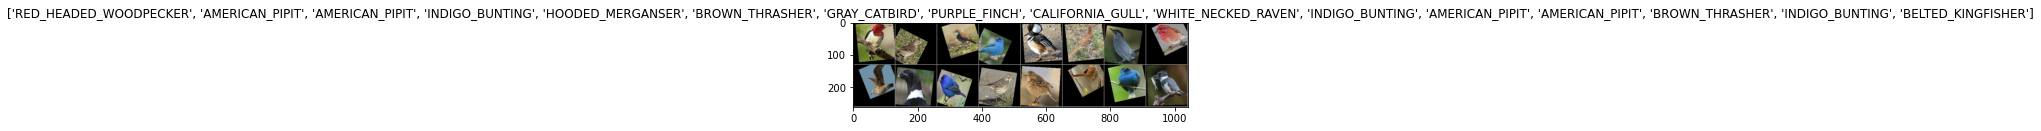

In [8]:
# 데이터가 제대로 들어왔는지 확인하기 위해 pyplot을 통한 이미지 출력
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([.5, .5, .5])
    std = np.array([.5, .5, .5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# valid 데이터 배치사이즈만틈 이미지 출력함
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# 학습 데이터의 배치
inputs, classes = next(iter(dataloaders['val']))

# 배치로부터 격자 형태의 이미지
out = torchvision.utils.make_grid(inputs)

# 이미지 출력
imshow(out, title=[class_names[x] for x in classes])

## Step 3: Neural Network 생성
- Pretrained model을 허용하지 않습니다. (직접 모델을 설계해 주세요)


In [9]:
class USNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Sequential(
            # 3x128x128 input image 입력
            # kernel_size 3x3 인 32개의 특징맵(feature map)으로 Conv필터 연산, padding은 1로하여 연산 진행
            nn.Conv2d(3,32,3, padding=1),
            # 연산된 평균과 분산을 조정하기 위한 BatchNormalization
            nn.BatchNorm2d(32),
            # 연산 값이 0보다 크면 그대로 값, 0보다 작으면 0 값을 반환하는 활성 함수 ReLU 적용
            nn.ReLU(True),
            # 정해진 filter 크기 안에서 가장 큰 값만 뽑아냄
            nn.MaxPool2d(2, stride=2),
            
            # 첫번째 레이어 연산 후 크기
            # 32x64x64 입력
            # kernel_size 3x3 인 64개의 특징맵(feature map)으로 Conv필터 연산, padding은 1로하여 연산 진행
            nn.Conv2d(32,64,3, padding=1),
            # 연산된 평균과 분산을 조정하기 위한 BatchNormalization
            nn.BatchNorm2d(64),
            # 연산 값이 0보다 크면 그대로 값, 0보다 작으면 0 값을 반환하는 활성 함수 ReLU 적용
            nn.ReLU(True),
            # 정해진 filter 크기 안에서 가장 큰 값만 뽑아냄
            nn.MaxPool2d(2, stride=2),
            # 과적합을 방지하기 위해 0.25 만큼 뉴런들을 누락시키기 위한 드롭아웃(Dropout) 적용
            nn.Dropout(0.25),
            
            # 두번째 레이어 연산 후 크기
            # 64x32x32 입력
            # kernel_size 3x3 인 128개의 특징맵(feature map)으로 Conv필터 연산, padding은 1로하여 연산 진행
            nn.Conv2d(64,128,3, padding=1),
            # 연산된 평균과 분산을 조정하기 위한 BatchNormalization
            nn.BatchNorm2d(128),
            # 연산 값이 0보다 크면 그대로 값, 0보다 작으면 0 값을 반환하는 활성 함수 ReLU 적용
            nn.ReLU(True),
            # 정해진 filter 크기 안에서 가장 큰 값만 뽑아냄
            nn.MaxPool2d(2, stride=2),
            
            # 세번째 레이어 연산 후 크기
            # 128*16*16 입력
            # kernel_size 3x3 인 256개의 특징맵(feature map)으로 Conv필터 연산, padding은 1로하여 연산 진행
            nn.Conv2d(128,256,3, padding=1),
            # 연산된 평균과 분산을 조정하기 위한 BatchNormalization
            nn.BatchNorm2d(256),
            # 연산 값이 0보다 크면 그대로 값, 0보다 작으면 0 값을 반환하는 활성 함수 ReLU 적용
            nn.ReLU(True),
            # 정해진 filter 크기 안에서 가장 큰 값만 뽑아냄
            nn.MaxPool2d(2, stride=2),
            # 과적합을 방지하기 위해 0.25 만큼 뉴런들을 누락시키기 위한 드롭아웃(Dropout) 적용
            nn.Dropout(0.25),
            
            # 네번째 레이어 연산 후 크기
            # 256*8*8 입력
            # kernel_size 3x3 인 512개의 특징맵(feature map)으로 Conv필터 연산, padding은 1로하여 연산 진행
            nn.Conv2d(256,512,3, padding=1),
            # 연산된 평균과 분산을 조정하기 위한 BatchNormalization
            nn.BatchNorm2d(512),
            # 연산 값이 0보다 크면 그대로 값, 0보다 작으면 0 값을 반환하는 활성 함수 ReLU 적용
            nn.ReLU(True),
            # 정해진 filter 크기 안에서 가장 큰 값만 뽑아냄
            nn.MaxPool2d(2, stride=2),
            
            
            # Conv 연산 후 최종 Output
            # 512*4*4
        )
        
        # 컨볼루션 연산을 거친 이미지를 다음 일반 신경망을 거치도록 Linear 정의
        # 앞 계층의 출력 크기 512x4x4를 입력, 출력 크기를 4096으로 설정
        self.fc1 = nn.Linear(512*4*4, 4096)
        # 두번째 Linear 또한 앞 크기 4096를 입력, 출력 크기를 15(새 종류 15 클래스)로 설정
        self.fc2 = nn.Linear(4096, 15)
        
        #activation function (ReLU)
        self.relu = nn.ReLU(True)
        
        #dropout layer
        self.dropout = nn.Dropout(0.5)
        #Batch Normalization
        self.BN = nn.BatchNorm1d(4096)
         
                
    def forward(self, x):
        # 위 컨볼루션 연산을 통해 얻어진 특징 맵(Feature map) x
        x = self.conv(x)
      
        # flatten image layer
        # 2차원 특징 맵을 view()함수를 통해 1차원으로 flatten
        # x.size(0)은 x가 가진 원소 개수, -1은 남는 차원 전부를 뜻함
        x = x.view(x.size(0), -1) 
        # 1차원으로 펴준 x를 다시 첫번째 Linear에 입력, Batch Normalization와 ReLU를 거침
        x = self.relu(self.BN(self.fc1(x)))
        # 과적합 방지를 위해 0.5만큼 뉴런들을 누락시키기 위한 드롭아웃(Dropout) 적용
        x = self.dropout(x)
        # 마지막 Linear 계층을 통해 출력값 반환
        x = self.fc2(x)
        
        return x
    
# 완성된 모델 USNet 생성(create a complete my model)
model = USNet()

# Cuda로 장치 이동(move tensors to GPU if CUDA is available.)
model.to(device)

USNet(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.25, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d

 ## Step 4: Cost (Loss) Function 과 Optimizer 선택
 
 [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) 및 [optimizer](http://pytorch.org/docs/stable/optim.html)를 선택하여 코드를 완성하세요.
 
 위 링크에서 다양한 Loss Function과 Optimize Function을 확인 할 수 있습니다
 

In [10]:
# 실제 값과 예측값의 차이에 대한 오차를 계산해주는 CrossEntropyLoss 손실 함수(Loss Function) 적용
criterion = nn.CrossEntropyLoss()

# 기울기 값으로 모델의 학습 파라미터를 업데이트하기 위한 최적화 함수 중 Adam Optimizer 사용
# 학습률(Learning Rate)은 0.001 , 과적합을 억제하기 위한 가중치 감소 weight decay 또한 0.001(1e-2) 적용
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-2)
# 20epoch, 50epoch에 학습률(Learning Rate)을 0.1의 감소량 만큼 감소시켜주는 Scheduler 적용
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 50], gamma=0.1)

## Step 5: 구성한 모델에 대한 Train and Validate 진행

* 코드 전체를 주석으로 설명하세요
* Epoch 별로 Loss나 Accuracy를 출력하여 학습 진행 과정을 확인 할 수 있도록 합니다
* 출력 예시는 주어지나 정해진 형식은 없습니다
* 최적의 모델 저장

예제:
```
Started Training...
Epoch: 1 	Training Loss: 3.317162 	Validation Loss: 4.162958
Epoch: 2 	Training Loss: 2.420140 	Validation Loss: 4.182362
...
...
Finished training
```

In [11]:
# 학습 진행률을 보기 위해 진행상태바 라이브러리 tqdm 사용
from tqdm.notebook import tqdm, trange

# Hyper Parameter tuning
# epoch 횟수
n_epochs = 500

# track change in validation loss
# validation loss, accuracy 값 초기화
valid_loss_min = np.Inf
valid_acc_max = 0

# track change in train loss
# train loss, accuracy 값 초기화
train_loss_min = np.Inf
train_acc_max = 0

# keep track of training and validation loss
# train, valid loss와 accuracy 초기화
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)

for i in trange(0, n_epochs):
    # epoch 수 확인을 위한 출력
    print('epoch = ', i)
    
    # train model
    model.train()
    # train data 학습
    for data, labels in tqdm(dataloaders["train"]):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        
        # clear the gradients of all optimized variables
        # 모든 최적화된 변수들의 기울기 값 초기화
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        # 예측된 결과 값을 연산하기 위한 forward 진행
        logits = model(data)
        # calculate the batch loss
        # loss 값 계산
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        # 모델 매개 변수에 대한 손실 기울기 계산을 위해 역전파 진행
        loss.backward()
        # perform a single optimization step (parameter update)
        # 파라미터 업데이트를 위한 최적화 단계 수행 
        optimizer.step()
        # update training loss
        train_loss[i] += loss.item()
        
        # 예측된 결과 값 (logits)를 softmax 함수를 통해 총합이 1이 되는 0~1 사이의 값으로 ps 저장
        ps = F.softmax(logits, dim=1)
        # 저장된 ps 값 중에 가장 높은 값 top_p, 해당 클래스 top_class에 저장
        top_p, top_class = ps.topk(1, dim=1)
        # 예측된 top_class 라벨과 실제 라벨이 일치하면 equals는 true
        equals = top_class == labels.reshape(top_class.shape)
        # equals 논리값을 실수형으로 변환 후 맞춘 개수 train_acc에 저장
        train_acc[i] += torch.mean(equals.type(torch.float)).detach().cpu()

    # i번째 epoch에 따른 train loss와 train_acc 계산
    train_loss[i] /= len(dataloaders["train"])
    train_acc[i] /= len(dataloaders["train"])

    # validate the model 
    with torch.no_grad():
        # 모델 평가 진행
        model.eval()
        # validation data 평가
        for data, labels in tqdm(dataloaders["val"]):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            
            # forward pass: compute predicted outputs by passing inputs to the model
            # 예측된 결과 값을 연산하기 위한 forward 진행
            logits = model(data)
            # calculate the batch loss
            # loss 값 계산
            loss = criterion(logits, labels)
            # update average validation loss
            # 평균 validation loss 업데이트
            valid_loss[i] += loss.item()
            
            # 예측된 결과 값 (logits)를 softmax 함수를 통해 총합이 1이 되는 0~1 사이의 값으로 ps 저장
            ps = F.softmax(logits, dim=1)
            # 저장된 ps 값 중에 가장 높은 값 top_p, 해당 클래스 top_class에 저장
            top_p, top_class = ps.topk(1, dim=1)
            # 예측된 top_class 라벨과 실제 라벨이 일치하면 equals는 true
            equals = top_class == labels.reshape(top_class.shape)
            # equals 논리값을 실수형으로 변환 후 맞춘 개수 valid_acc에 저장
            valid_acc[i] += torch.mean(equals.type(torch.float)).detach().cpu()

    # calculate average losses
    # i번째 epoch에 따른 valid loss와 valid_acc 계산
    valid_loss[i] /= len(dataloaders["val"])
    valid_acc[i] /= len(dataloaders["val"])
    
    
    # print training/validation statistics
    # epoch 마다 training loss 와 validation loss 출력
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(i, train_loss[i], valid_loss[i]))

    # print training/validation statistics
    # epoch 마다 training accuracy 와 validation accuracy 출력
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(i, train_acc[i], valid_acc[i]))
    
    # scheduler 수행
    scheduler.step()
    
    # save model if validation loss has decreased
    # validation loss 가 감소하면 모델을 저장
    if valid_loss[i] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss[i]))
        torch.save(model.state_dict(), 'model_useung.pt')
        valid_loss_min = valid_loss[i]
        train_loss_min = train_loss[i]
        valid_acc_max = valid_acc[i]
        train_acc_max = train_acc[i]


# 학습 완료 후 최종 모델
print("...Training Finish\n\n")
print("=================Best Model=================\n")

print('Loss Score : \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss_min, valid_loss_min))

# print training/validation statistics 
print('Accuracy Score : \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(train_acc_max, valid_acc_max))
print("\n============================================")

  0%|          | 0/500 [00:00<?, ?it/s]

epoch =  0


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 0 	Training Loss: 1.953382 	Validation Loss: 2.306778
Epoch: 0 	Training accuracy: 0.429282 	Validation accuracy: 0.321805
Validation loss decreased (inf --> 2.306778).  Saving model ...
epoch =  1


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.345020 	Validation Loss: 2.872532
Epoch: 1 	Training accuracy: 0.598133 	Validation accuracy: 0.330335
epoch =  2


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.241988 	Validation Loss: 2.516674
Epoch: 2 	Training accuracy: 0.629076 	Validation accuracy: 0.387872
epoch =  3


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.180354 	Validation Loss: 2.365560
Epoch: 3 	Training accuracy: 0.640472 	Validation accuracy: 0.399969
epoch =  4


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.092604 	Validation Loss: 2.455487
Epoch: 4 	Training accuracy: 0.655395 	Validation accuracy: 0.317308
epoch =  5


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 1.055962 	Validation Loss: 1.859829
Epoch: 5 	Training accuracy: 0.671196 	Validation accuracy: 0.440447
Validation loss decreased (2.306778 --> 1.859829).  Saving model ...
epoch =  6


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 1.050673 	Validation Loss: 1.867658
Epoch: 6 	Training accuracy: 0.674636 	Validation accuracy: 0.452854
epoch =  7


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.012788 	Validation Loss: 1.958472
Epoch: 7 	Training accuracy: 0.685309 	Validation accuracy: 0.433158
epoch =  8


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.911267 	Validation Loss: 1.527106
Epoch: 8 	Training accuracy: 0.711628 	Validation accuracy: 0.542029
Validation loss decreased (1.859829 --> 1.527106).  Saving model ...
epoch =  9


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.888559 	Validation Loss: 1.605884
Epoch: 9 	Training accuracy: 0.725938 	Validation accuracy: 0.521867
epoch =  10


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.915672 	Validation Loss: 1.490755
Epoch: 10 	Training accuracy: 0.715331 	Validation accuracy: 0.545596
Validation loss decreased (1.527106 --> 1.490755).  Saving model ...
epoch =  11


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.885913 	Validation Loss: 1.761818
Epoch: 11 	Training accuracy: 0.711124 	Validation accuracy: 0.468362
epoch =  12


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.830916 	Validation Loss: 2.199401
Epoch: 12 	Training accuracy: 0.736216 	Validation accuracy: 0.384305
epoch =  13


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.823329 	Validation Loss: 2.203533
Epoch: 13 	Training accuracy: 0.746494 	Validation accuracy: 0.412531
epoch =  14


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.847077 	Validation Loss: 1.749457
Epoch: 14 	Training accuracy: 0.731395 	Validation accuracy: 0.440757
epoch =  15


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.787468 	Validation Loss: 1.645660
Epoch: 15 	Training accuracy: 0.760607 	Validation accuracy: 0.473480
epoch =  16


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.797876 	Validation Loss: 1.820676
Epoch: 16 	Training accuracy: 0.757298 	Validation accuracy: 0.427730
epoch =  17


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.760930 	Validation Loss: 1.701151
Epoch: 17 	Training accuracy: 0.775925 	Validation accuracy: 0.487128
epoch =  18


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.762785 	Validation Loss: 1.588729
Epoch: 18 	Training accuracy: 0.766370 	Validation accuracy: 0.503877
epoch =  19


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.780845 	Validation Loss: 1.403129
Epoch: 19 	Training accuracy: 0.766655 	Validation accuracy: 0.550093
Validation loss decreased (1.490755 --> 1.403129).  Saving model ...
epoch =  20


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.539754 	Validation Loss: 1.263607
Epoch: 20 	Training accuracy: 0.845481 	Validation accuracy: 0.626706
Validation loss decreased (1.403129 --> 1.263607).  Saving model ...
epoch =  21


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.412891 	Validation Loss: 1.083505
Epoch: 21 	Training accuracy: 0.888521 	Validation accuracy: 0.662996
Validation loss decreased (1.263607 --> 1.083505).  Saving model ...
epoch =  22


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.375410 	Validation Loss: 1.046130
Epoch: 22 	Training accuracy: 0.897901 	Validation accuracy: 0.683623
Validation loss decreased (1.083505 --> 1.046130).  Saving model ...
epoch =  23


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.331416 	Validation Loss: 1.184932
Epoch: 23 	Training accuracy: 0.911093 	Validation accuracy: 0.618641
epoch =  24


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.303367 	Validation Loss: 1.054513
Epoch: 24 	Training accuracy: 0.923606 	Validation accuracy: 0.692618
epoch =  25


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.305209 	Validation Loss: 1.038156
Epoch: 25 	Training accuracy: 0.922993 	Validation accuracy: 0.674473
Validation loss decreased (1.046130 --> 1.038156).  Saving model ...
epoch =  26


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.299793 	Validation Loss: 1.014898
Epoch: 26 	Training accuracy: 0.925622 	Validation accuracy: 0.683623
Validation loss decreased (1.038156 --> 1.014898).  Saving model ...
epoch =  27


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.295284 	Validation Loss: 0.987064
Epoch: 27 	Training accuracy: 0.935703 	Validation accuracy: 0.691687
Validation loss decreased (1.014898 --> 0.987064).  Saving model ...
epoch =  28


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.278529 	Validation Loss: 0.977217
Epoch: 28 	Training accuracy: 0.933468 	Validation accuracy: 0.707816
Validation loss decreased (0.987064 --> 0.977217).  Saving model ...
epoch =  29


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.273601 	Validation Loss: 1.020938
Epoch: 29 	Training accuracy: 0.941445 	Validation accuracy: 0.663462
epoch =  30


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.259709 	Validation Loss: 0.973012
Epoch: 30 	Training accuracy: 0.936602 	Validation accuracy: 0.703784
Validation loss decreased (0.977217 --> 0.973012).  Saving model ...
epoch =  31


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.243624 	Validation Loss: 0.987051
Epoch: 31 	Training accuracy: 0.947383 	Validation accuracy: 0.694169
epoch =  32


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.249477 	Validation Loss: 0.918375
Epoch: 32 	Training accuracy: 0.945871 	Validation accuracy: 0.720999
Validation loss decreased (0.973012 --> 0.918375).  Saving model ...
epoch =  33


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.251306 	Validation Loss: 0.923040
Epoch: 33 	Training accuracy: 0.949093 	Validation accuracy: 0.714950
epoch =  34


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.224498 	Validation Loss: 0.877143
Epoch: 34 	Training accuracy: 0.962000 	Validation accuracy: 0.742556
Validation loss decreased (0.918375 --> 0.877143).  Saving model ...
epoch =  35


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.224501 	Validation Loss: 0.881459
Epoch: 35 	Training accuracy: 0.958889 	Validation accuracy: 0.735577
epoch =  36


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.242687 	Validation Loss: 0.897204
Epoch: 36 	Training accuracy: 0.949400 	Validation accuracy: 0.718362
epoch =  37


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.227493 	Validation Loss: 0.883059
Epoch: 37 	Training accuracy: 0.949202 	Validation accuracy: 0.723480
epoch =  38


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.213585 	Validation Loss: 0.917398
Epoch: 38 	Training accuracy: 0.961496 	Validation accuracy: 0.736042
epoch =  39


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.212327 	Validation Loss: 0.864989
Epoch: 39 	Training accuracy: 0.957157 	Validation accuracy: 0.732010
Validation loss decreased (0.877143 --> 0.864989).  Saving model ...
epoch =  40


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.220403 	Validation Loss: 0.956955
Epoch: 40 	Training accuracy: 0.953235 	Validation accuracy: 0.709833
epoch =  41


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.214399 	Validation Loss: 0.962857
Epoch: 41 	Training accuracy: 0.961190 	Validation accuracy: 0.701303
epoch =  42


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.182373 	Validation Loss: 0.887877
Epoch: 42 	Training accuracy: 0.970065 	Validation accuracy: 0.743021
epoch =  43


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.199222 	Validation Loss: 0.979692
Epoch: 43 	Training accuracy: 0.973286 	Validation accuracy: 0.704249
epoch =  44


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 44 	Training Loss: 0.218434 	Validation Loss: 0.987465
Epoch: 44 	Training accuracy: 0.953739 	Validation accuracy: 0.695254
epoch =  45


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 45 	Training Loss: 0.196495 	Validation Loss: 0.803913
Epoch: 45 	Training accuracy: 0.972388 	Validation accuracy: 0.781483
Validation loss decreased (0.864989 --> 0.803913).  Saving model ...
epoch =  46


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.196841 	Validation Loss: 0.920847
Epoch: 46 	Training accuracy: 0.968553 	Validation accuracy: 0.716346
epoch =  47


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 47 	Training Loss: 0.162534 	Validation Loss: 0.976398
Epoch: 47 	Training accuracy: 0.979137 	Validation accuracy: 0.699752
epoch =  48


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.162130 	Validation Loss: 0.840517
Epoch: 48 	Training accuracy: 0.981855 	Validation accuracy: 0.749225
epoch =  49


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.178395 	Validation Loss: 0.880967
Epoch: 49 	Training accuracy: 0.975105 	Validation accuracy: 0.733406
epoch =  50


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 50 	Training Loss: 0.146944 	Validation Loss: 0.823982
Epoch: 50 	Training accuracy: 0.982973 	Validation accuracy: 0.748139
epoch =  51


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 51 	Training Loss: 0.125127 	Validation Loss: 0.709607
Epoch: 51 	Training accuracy: 0.991935 	Validation accuracy: 0.788927
Validation loss decreased (0.803913 --> 0.709607).  Saving model ...
epoch =  52


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 52 	Training Loss: 0.122995 	Validation Loss: 0.732413
Epoch: 52 	Training accuracy: 0.987903 	Validation accuracy: 0.770316
epoch =  53


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 53 	Training Loss: 0.113343 	Validation Loss: 0.820251
Epoch: 53 	Training accuracy: 0.991431 	Validation accuracy: 0.751551
epoch =  54


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 54 	Training Loss: 0.115144 	Validation Loss: 0.683616
Epoch: 54 	Training accuracy: 0.991935 	Validation accuracy: 0.818083
Validation loss decreased (0.709607 --> 0.683616).  Saving model ...
epoch =  55


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 55 	Training Loss: 0.104890 	Validation Loss: 0.828487
Epoch: 55 	Training accuracy: 0.992944 	Validation accuracy: 0.754187
epoch =  56


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 56 	Training Loss: 0.101611 	Validation Loss: 0.749273
Epoch: 56 	Training accuracy: 0.990927 	Validation accuracy: 0.761166
epoch =  57


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 57 	Training Loss: 0.096159 	Validation Loss: 0.659134
Epoch: 57 	Training accuracy: 0.994456 	Validation accuracy: 0.813120
Validation loss decreased (0.683616 --> 0.659134).  Saving model ...
epoch =  58


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 58 	Training Loss: 0.094154 	Validation Loss: 0.738643
Epoch: 58 	Training accuracy: 0.991935 	Validation accuracy: 0.780862
epoch =  59


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 59 	Training Loss: 0.107554 	Validation Loss: 0.697608
Epoch: 59 	Training accuracy: 0.990927 	Validation accuracy: 0.790943
epoch =  60


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 60 	Training Loss: 0.088214 	Validation Loss: 0.798150
Epoch: 60 	Training accuracy: 0.994456 	Validation accuracy: 0.777916
epoch =  61


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 61 	Training Loss: 0.095315 	Validation Loss: 0.726545
Epoch: 61 	Training accuracy: 0.992944 	Validation accuracy: 0.805056
epoch =  62


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 62 	Training Loss: 0.091941 	Validation Loss: 0.736914
Epoch: 62 	Training accuracy: 0.994456 	Validation accuracy: 0.779777
epoch =  63


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 63 	Training Loss: 0.087506 	Validation Loss: 0.773366
Epoch: 63 	Training accuracy: 0.995464 	Validation accuracy: 0.767215
epoch =  64


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 64 	Training Loss: 0.082541 	Validation Loss: 0.697081
Epoch: 64 	Training accuracy: 0.997984 	Validation accuracy: 0.809088
epoch =  65


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 65 	Training Loss: 0.082560 	Validation Loss: 0.727913
Epoch: 65 	Training accuracy: 0.997480 	Validation accuracy: 0.791408
epoch =  66


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 66 	Training Loss: 0.074980 	Validation Loss: 0.724531
Epoch: 66 	Training accuracy: 0.998992 	Validation accuracy: 0.799007
epoch =  67


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 67 	Training Loss: 0.081881 	Validation Loss: 0.685675
Epoch: 67 	Training accuracy: 0.997480 	Validation accuracy: 0.798542
epoch =  68


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 68 	Training Loss: 0.081384 	Validation Loss: 0.718509
Epoch: 68 	Training accuracy: 0.997984 	Validation accuracy: 0.778846
epoch =  69


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 69 	Training Loss: 0.081722 	Validation Loss: 0.698603
Epoch: 69 	Training accuracy: 0.995771 	Validation accuracy: 0.791408
epoch =  70


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 70 	Training Loss: 0.093714 	Validation Loss: 0.690592
Epoch: 70 	Training accuracy: 0.994456 	Validation accuracy: 0.793424
epoch =  71


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 71 	Training Loss: 0.083907 	Validation Loss: 0.709069
Epoch: 71 	Training accuracy: 0.998488 	Validation accuracy: 0.788462
epoch =  72


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 72 	Training Loss: 0.077098 	Validation Loss: 0.689676
Epoch: 72 	Training accuracy: 0.996275 	Validation accuracy: 0.796526
epoch =  73


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 73 	Training Loss: 0.081817 	Validation Loss: 0.783097
Epoch: 73 	Training accuracy: 0.995968 	Validation accuracy: 0.755118
epoch =  74


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 74 	Training Loss: 0.078614 	Validation Loss: 0.731741
Epoch: 74 	Training accuracy: 0.996976 	Validation accuracy: 0.782413
epoch =  75


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 75 	Training Loss: 0.082473 	Validation Loss: 0.725640
Epoch: 75 	Training accuracy: 0.995968 	Validation accuracy: 0.773883
epoch =  76


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 76 	Training Loss: 0.074053 	Validation Loss: 0.704069
Epoch: 76 	Training accuracy: 0.997283 	Validation accuracy: 0.794510
epoch =  77


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 77 	Training Loss: 0.081213 	Validation Loss: 0.750720
Epoch: 77 	Training accuracy: 0.996472 	Validation accuracy: 0.796991
epoch =  78


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 78 	Training Loss: 0.080302 	Validation Loss: 0.780644
Epoch: 78 	Training accuracy: 0.998992 	Validation accuracy: 0.766284
epoch =  79


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 79 	Training Loss: 0.082732 	Validation Loss: 0.691647
Epoch: 79 	Training accuracy: 0.996472 	Validation accuracy: 0.787376
epoch =  80


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 80 	Training Loss: 0.075706 	Validation Loss: 0.724846
Epoch: 80 	Training accuracy: 0.997480 	Validation accuracy: 0.777761
epoch =  81


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 81 	Training Loss: 0.076570 	Validation Loss: 0.730971
Epoch: 81 	Training accuracy: 0.997984 	Validation accuracy: 0.758685
epoch =  82


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 82 	Training Loss: 0.069272 	Validation Loss: 0.757412
Epoch: 82 	Training accuracy: 0.998992 	Validation accuracy: 0.776365
epoch =  83


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 83 	Training Loss: 0.084146 	Validation Loss: 0.690511
Epoch: 83 	Training accuracy: 0.997480 	Validation accuracy: 0.786911
epoch =  84


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 84 	Training Loss: 0.082643 	Validation Loss: 0.650954
Epoch: 84 	Training accuracy: 0.993952 	Validation accuracy: 0.839330
Validation loss decreased (0.659134 --> 0.650954).  Saving model ...
epoch =  85


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 85 	Training Loss: 0.077709 	Validation Loss: 0.742318
Epoch: 85 	Training accuracy: 0.997283 	Validation accuracy: 0.803970
epoch =  86


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 86 	Training Loss: 0.078342 	Validation Loss: 0.721309
Epoch: 86 	Training accuracy: 0.997480 	Validation accuracy: 0.775279
epoch =  87


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 87 	Training Loss: 0.082148 	Validation Loss: 0.688935
Epoch: 87 	Training accuracy: 0.997480 	Validation accuracy: 0.813586
epoch =  88


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 88 	Training Loss: 0.082926 	Validation Loss: 0.701527
Epoch: 88 	Training accuracy: 0.997480 	Validation accuracy: 0.794355
epoch =  89


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 89 	Training Loss: 0.077487 	Validation Loss: 0.694458
Epoch: 89 	Training accuracy: 0.998992 	Validation accuracy: 0.811104
epoch =  90


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 90 	Training Loss: 0.078401 	Validation Loss: 0.721852
Epoch: 90 	Training accuracy: 0.997480 	Validation accuracy: 0.791873
epoch =  91


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 91 	Training Loss: 0.082003 	Validation Loss: 0.728887
Epoch: 91 	Training accuracy: 0.994960 	Validation accuracy: 0.799473
epoch =  92


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 92 	Training Loss: 0.073569 	Validation Loss: 0.670168
Epoch: 92 	Training accuracy: 0.998992 	Validation accuracy: 0.802574
epoch =  93


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 93 	Training Loss: 0.079953 	Validation Loss: 0.717302
Epoch: 93 	Training accuracy: 0.998992 	Validation accuracy: 0.792029
epoch =  94


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 94 	Training Loss: 0.074973 	Validation Loss: 0.734230
Epoch: 94 	Training accuracy: 1.000000 	Validation accuracy: 0.792494
epoch =  95


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 95 	Training Loss: 0.076692 	Validation Loss: 0.651584
Epoch: 95 	Training accuracy: 0.997480 	Validation accuracy: 0.811104
epoch =  96


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 96 	Training Loss: 0.076546 	Validation Loss: 0.671108
Epoch: 96 	Training accuracy: 0.998992 	Validation accuracy: 0.811569
epoch =  97


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 97 	Training Loss: 0.079014 	Validation Loss: 0.754758
Epoch: 97 	Training accuracy: 0.997984 	Validation accuracy: 0.786445
epoch =  98


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 98 	Training Loss: 0.073980 	Validation Loss: 0.738119
Epoch: 98 	Training accuracy: 0.998488 	Validation accuracy: 0.792029
epoch =  99


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 99 	Training Loss: 0.073669 	Validation Loss: 0.715664
Epoch: 99 	Training accuracy: 0.998488 	Validation accuracy: 0.797457
epoch =  100


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 100 	Training Loss: 0.077940 	Validation Loss: 0.712664
Epoch: 100 	Training accuracy: 0.996976 	Validation accuracy: 0.807072
epoch =  101


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 101 	Training Loss: 0.074605 	Validation Loss: 0.665624
Epoch: 101 	Training accuracy: 0.998488 	Validation accuracy: 0.821650
epoch =  102


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 102 	Training Loss: 0.078275 	Validation Loss: 0.668945
Epoch: 102 	Training accuracy: 0.997984 	Validation accuracy: 0.792959
epoch =  103


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 103 	Training Loss: 0.074872 	Validation Loss: 0.733514
Epoch: 103 	Training accuracy: 0.998488 	Validation accuracy: 0.790478
epoch =  104


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 104 	Training Loss: 0.076722 	Validation Loss: 0.690612
Epoch: 104 	Training accuracy: 0.998488 	Validation accuracy: 0.796526
epoch =  105


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 105 	Training Loss: 0.076436 	Validation Loss: 0.697215
Epoch: 105 	Training accuracy: 0.997984 	Validation accuracy: 0.808158
epoch =  106


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 106 	Training Loss: 0.075044 	Validation Loss: 0.754028
Epoch: 106 	Training accuracy: 0.998488 	Validation accuracy: 0.783344
epoch =  107


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 107 	Training Loss: 0.080772 	Validation Loss: 0.664917
Epoch: 107 	Training accuracy: 0.998488 	Validation accuracy: 0.815602
epoch =  108


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 108 	Training Loss: 0.080277 	Validation Loss: 0.726858
Epoch: 108 	Training accuracy: 0.997984 	Validation accuracy: 0.789392
epoch =  109


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 109 	Training Loss: 0.084204 	Validation Loss: 0.693675
Epoch: 109 	Training accuracy: 0.997984 	Validation accuracy: 0.792494
epoch =  110


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 110 	Training Loss: 0.081323 	Validation Loss: 0.690507
Epoch: 110 	Training accuracy: 0.999496 	Validation accuracy: 0.809553
epoch =  111


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 111 	Training Loss: 0.078855 	Validation Loss: 0.771896
Epoch: 111 	Training accuracy: 0.999496 	Validation accuracy: 0.789392
epoch =  112


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 112 	Training Loss: 0.073548 	Validation Loss: 0.786915
Epoch: 112 	Training accuracy: 0.998992 	Validation accuracy: 0.783809
epoch =  113


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 113 	Training Loss: 0.080391 	Validation Loss: 0.793189
Epoch: 113 	Training accuracy: 0.998488 	Validation accuracy: 0.769231
epoch =  114


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 114 	Training Loss: 0.080105 	Validation Loss: 0.751390
Epoch: 114 	Training accuracy: 0.997984 	Validation accuracy: 0.787841
epoch =  115


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 115 	Training Loss: 0.083010 	Validation Loss: 0.728963
Epoch: 115 	Training accuracy: 0.997984 	Validation accuracy: 0.795596
epoch =  116


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 116 	Training Loss: 0.082168 	Validation Loss: 0.753550
Epoch: 116 	Training accuracy: 0.998488 	Validation accuracy: 0.763648
epoch =  117


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 117 	Training Loss: 0.080345 	Validation Loss: 0.731875
Epoch: 117 	Training accuracy: 0.998992 	Validation accuracy: 0.778846
epoch =  118


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 118 	Training Loss: 0.077314 	Validation Loss: 0.714718
Epoch: 118 	Training accuracy: 0.998992 	Validation accuracy: 0.783344
epoch =  119


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 119 	Training Loss: 0.078834 	Validation Loss: 0.686148
Epoch: 119 	Training accuracy: 0.997984 	Validation accuracy: 0.793579
epoch =  120


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 120 	Training Loss: 0.075123 	Validation Loss: 0.739527
Epoch: 120 	Training accuracy: 1.000000 	Validation accuracy: 0.786290
epoch =  121


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 121 	Training Loss: 0.079065 	Validation Loss: 0.738633
Epoch: 121 	Training accuracy: 0.998488 	Validation accuracy: 0.777295
epoch =  122


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 122 	Training Loss: 0.079098 	Validation Loss: 0.677547
Epoch: 122 	Training accuracy: 0.999496 	Validation accuracy: 0.813586
epoch =  123


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 123 	Training Loss: 0.077859 	Validation Loss: 0.704188
Epoch: 123 	Training accuracy: 0.998488 	Validation accuracy: 0.804591
epoch =  124


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 124 	Training Loss: 0.078464 	Validation Loss: 0.729891
Epoch: 124 	Training accuracy: 0.998992 	Validation accuracy: 0.797457
epoch =  125


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 125 	Training Loss: 0.075581 	Validation Loss: 0.722892
Epoch: 125 	Training accuracy: 0.999496 	Validation accuracy: 0.772798
epoch =  126


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 126 	Training Loss: 0.079826 	Validation Loss: 0.694027
Epoch: 126 	Training accuracy: 0.999496 	Validation accuracy: 0.805986
epoch =  127


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 127 	Training Loss: 0.077919 	Validation Loss: 0.743930
Epoch: 127 	Training accuracy: 0.998992 	Validation accuracy: 0.794975
epoch =  128


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 128 	Training Loss: 0.073204 	Validation Loss: 0.655863
Epoch: 128 	Training accuracy: 1.000000 	Validation accuracy: 0.833747
epoch =  129


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 129 	Training Loss: 0.082054 	Validation Loss: 0.661062
Epoch: 129 	Training accuracy: 1.000000 	Validation accuracy: 0.813586
epoch =  130


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 130 	Training Loss: 0.083659 	Validation Loss: 0.673806
Epoch: 130 	Training accuracy: 0.997984 	Validation accuracy: 0.817618
epoch =  131


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 131 	Training Loss: 0.078971 	Validation Loss: 0.706984
Epoch: 131 	Training accuracy: 0.998992 	Validation accuracy: 0.793890
epoch =  132


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 132 	Training Loss: 0.080295 	Validation Loss: 0.640708
Epoch: 132 	Training accuracy: 0.998291 	Validation accuracy: 0.824131
Validation loss decreased (0.650954 --> 0.640708).  Saving model ...
epoch =  133


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 133 	Training Loss: 0.075463 	Validation Loss: 0.689629
Epoch: 133 	Training accuracy: 0.999496 	Validation accuracy: 0.805986
epoch =  134


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 134 	Training Loss: 0.080331 	Validation Loss: 0.704575
Epoch: 134 	Training accuracy: 1.000000 	Validation accuracy: 0.797922
epoch =  135


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 135 	Training Loss: 0.078869 	Validation Loss: 0.713322
Epoch: 135 	Training accuracy: 1.000000 	Validation accuracy: 0.803505
epoch =  136


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 136 	Training Loss: 0.079540 	Validation Loss: 0.757678
Epoch: 136 	Training accuracy: 0.998488 	Validation accuracy: 0.801024
epoch =  137


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 137 	Training Loss: 0.075558 	Validation Loss: 0.695617
Epoch: 137 	Training accuracy: 0.998992 	Validation accuracy: 0.797457
epoch =  138


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 138 	Training Loss: 0.076012 	Validation Loss: 0.764544
Epoch: 138 	Training accuracy: 0.998488 	Validation accuracy: 0.775744
epoch =  139


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 139 	Training Loss: 0.080015 	Validation Loss: 0.698933
Epoch: 139 	Training accuracy: 0.999496 	Validation accuracy: 0.794975
epoch =  140


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 140 	Training Loss: 0.077770 	Validation Loss: 0.748550
Epoch: 140 	Training accuracy: 1.000000 	Validation accuracy: 0.786911
epoch =  141


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 141 	Training Loss: 0.076586 	Validation Loss: 0.711434
Epoch: 141 	Training accuracy: 0.999496 	Validation accuracy: 0.808468
epoch =  142


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 142 	Training Loss: 0.076754 	Validation Loss: 0.722347
Epoch: 142 	Training accuracy: 0.999496 	Validation accuracy: 0.810639
epoch =  143


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 143 	Training Loss: 0.077550 	Validation Loss: 0.766786
Epoch: 143 	Training accuracy: 0.998992 	Validation accuracy: 0.799473
epoch =  144


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 144 	Training Loss: 0.079302 	Validation Loss: 0.723025
Epoch: 144 	Training accuracy: 0.999299 	Validation accuracy: 0.804125
epoch =  145


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 145 	Training Loss: 0.082081 	Validation Loss: 0.699441
Epoch: 145 	Training accuracy: 0.997984 	Validation accuracy: 0.818548
epoch =  146


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 146 	Training Loss: 0.080205 	Validation Loss: 0.745721
Epoch: 146 	Training accuracy: 0.999496 	Validation accuracy: 0.793890
epoch =  147


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 147 	Training Loss: 0.080724 	Validation Loss: 0.677317
Epoch: 147 	Training accuracy: 0.998795 	Validation accuracy: 0.822736
epoch =  148


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 148 	Training Loss: 0.079428 	Validation Loss: 0.737925
Epoch: 148 	Training accuracy: 0.997984 	Validation accuracy: 0.802109
epoch =  149


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 149 	Training Loss: 0.078994 	Validation Loss: 0.655938
Epoch: 149 	Training accuracy: 0.998992 	Validation accuracy: 0.817308
epoch =  150


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 150 	Training Loss: 0.075874 	Validation Loss: 0.731120
Epoch: 150 	Training accuracy: 1.000000 	Validation accuracy: 0.802109
epoch =  151


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 151 	Training Loss: 0.076206 	Validation Loss: 0.668020
Epoch: 151 	Training accuracy: 0.999496 	Validation accuracy: 0.819634
epoch =  152


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 152 	Training Loss: 0.076608 	Validation Loss: 0.685936
Epoch: 152 	Training accuracy: 0.999496 	Validation accuracy: 0.808002
epoch =  153


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 153 	Training Loss: 0.079440 	Validation Loss: 0.737848
Epoch: 153 	Training accuracy: 1.000000 	Validation accuracy: 0.797457
epoch =  154


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 154 	Training Loss: 0.074220 	Validation Loss: 0.699623
Epoch: 154 	Training accuracy: 0.999496 	Validation accuracy: 0.808002
epoch =  155


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 155 	Training Loss: 0.073372 	Validation Loss: 0.723158
Epoch: 155 	Training accuracy: 0.999496 	Validation accuracy: 0.793424
epoch =  156


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 156 	Training Loss: 0.079209 	Validation Loss: 0.766330
Epoch: 156 	Training accuracy: 0.998992 	Validation accuracy: 0.783499
epoch =  157


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 157 	Training Loss: 0.080325 	Validation Loss: 0.689968
Epoch: 157 	Training accuracy: 0.998992 	Validation accuracy: 0.810019
epoch =  158


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 158 	Training Loss: 0.081249 	Validation Loss: 0.661324
Epoch: 158 	Training accuracy: 0.999496 	Validation accuracy: 0.845378
epoch =  159


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 159 	Training Loss: 0.079564 	Validation Loss: 0.718659
Epoch: 159 	Training accuracy: 0.998488 	Validation accuracy: 0.781793
epoch =  160


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 160 	Training Loss: 0.076964 	Validation Loss: 0.630060
Epoch: 160 	Training accuracy: 0.998488 	Validation accuracy: 0.838865
Validation loss decreased (0.640708 --> 0.630060).  Saving model ...
epoch =  161


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 161 	Training Loss: 0.078731 	Validation Loss: 0.649070
Epoch: 161 	Training accuracy: 0.998488 	Validation accuracy: 0.829715
epoch =  162


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 162 	Training Loss: 0.077134 	Validation Loss: 0.727801
Epoch: 162 	Training accuracy: 0.999496 	Validation accuracy: 0.795906
epoch =  163


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 163 	Training Loss: 0.074276 	Validation Loss: 0.682158
Epoch: 163 	Training accuracy: 1.000000 	Validation accuracy: 0.835763
epoch =  164


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 164 	Training Loss: 0.075551 	Validation Loss: 0.720958
Epoch: 164 	Training accuracy: 0.999496 	Validation accuracy: 0.798542
epoch =  165


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 165 	Training Loss: 0.075162 	Validation Loss: 0.723804
Epoch: 165 	Training accuracy: 0.999496 	Validation accuracy: 0.803505
epoch =  166


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 166 	Training Loss: 0.072006 	Validation Loss: 0.678074
Epoch: 166 	Training accuracy: 1.000000 	Validation accuracy: 0.816687
epoch =  167


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 167 	Training Loss: 0.078469 	Validation Loss: 0.723777
Epoch: 167 	Training accuracy: 0.998992 	Validation accuracy: 0.814671
epoch =  168


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 168 	Training Loss: 0.074726 	Validation Loss: 0.693961
Epoch: 168 	Training accuracy: 0.998488 	Validation accuracy: 0.817153
epoch =  169


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 169 	Training Loss: 0.077891 	Validation Loss: 0.702126
Epoch: 169 	Training accuracy: 0.998488 	Validation accuracy: 0.798542
epoch =  170


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 170 	Training Loss: 0.074823 	Validation Loss: 0.758611
Epoch: 170 	Training accuracy: 0.999496 	Validation accuracy: 0.811569
epoch =  171


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 171 	Training Loss: 0.075390 	Validation Loss: 0.716101
Epoch: 171 	Training accuracy: 0.997984 	Validation accuracy: 0.802419
epoch =  172


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 172 	Training Loss: 0.078118 	Validation Loss: 0.701973
Epoch: 172 	Training accuracy: 0.999496 	Validation accuracy: 0.815136
epoch =  173


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 173 	Training Loss: 0.072663 	Validation Loss: 0.723894
Epoch: 173 	Training accuracy: 0.999496 	Validation accuracy: 0.790478
epoch =  174


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 174 	Training Loss: 0.078025 	Validation Loss: 0.707086
Epoch: 174 	Training accuracy: 0.998992 	Validation accuracy: 0.810019
epoch =  175


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 175 	Training Loss: 0.074864 	Validation Loss: 0.717868
Epoch: 175 	Training accuracy: 0.998992 	Validation accuracy: 0.791873
epoch =  176


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 176 	Training Loss: 0.073702 	Validation Loss: 0.700758
Epoch: 176 	Training accuracy: 0.999496 	Validation accuracy: 0.806607
epoch =  177


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 177 	Training Loss: 0.073323 	Validation Loss: 0.791923
Epoch: 177 	Training accuracy: 0.999496 	Validation accuracy: 0.764268
epoch =  178


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 178 	Training Loss: 0.075003 	Validation Loss: 0.688075
Epoch: 178 	Training accuracy: 0.999496 	Validation accuracy: 0.826613
epoch =  179


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 179 	Training Loss: 0.074742 	Validation Loss: 0.677878
Epoch: 179 	Training accuracy: 0.999496 	Validation accuracy: 0.795906
epoch =  180


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 180 	Training Loss: 0.077715 	Validation Loss: 0.725283
Epoch: 180 	Training accuracy: 0.998992 	Validation accuracy: 0.803040
epoch =  181


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 181 	Training Loss: 0.072470 	Validation Loss: 0.724528
Epoch: 181 	Training accuracy: 1.000000 	Validation accuracy: 0.808623
epoch =  182


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 182 	Training Loss: 0.077931 	Validation Loss: 0.726932
Epoch: 182 	Training accuracy: 0.998488 	Validation accuracy: 0.805521
epoch =  183


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 183 	Training Loss: 0.073599 	Validation Loss: 0.698009
Epoch: 183 	Training accuracy: 1.000000 	Validation accuracy: 0.819169
epoch =  184


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 184 	Training Loss: 0.075193 	Validation Loss: 0.770285
Epoch: 184 	Training accuracy: 1.000000 	Validation accuracy: 0.788462
epoch =  185


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 185 	Training Loss: 0.074420 	Validation Loss: 0.692760
Epoch: 185 	Training accuracy: 0.999496 	Validation accuracy: 0.821650
epoch =  186


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 186 	Training Loss: 0.079122 	Validation Loss: 0.704081
Epoch: 186 	Training accuracy: 1.000000 	Validation accuracy: 0.813120
epoch =  187


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 187 	Training Loss: 0.078156 	Validation Loss: 0.746239
Epoch: 187 	Training accuracy: 0.998992 	Validation accuracy: 0.787996
epoch =  188


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 188 	Training Loss: 0.079378 	Validation Loss: 0.755763
Epoch: 188 	Training accuracy: 0.998488 	Validation accuracy: 0.808623
epoch =  189


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 189 	Training Loss: 0.076035 	Validation Loss: 0.734047
Epoch: 189 	Training accuracy: 0.998488 	Validation accuracy: 0.813741
epoch =  190


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 190 	Training Loss: 0.074349 	Validation Loss: 0.760312
Epoch: 190 	Training accuracy: 0.998488 	Validation accuracy: 0.791408
epoch =  191


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 191 	Training Loss: 0.074690 	Validation Loss: 0.691874
Epoch: 191 	Training accuracy: 0.999496 	Validation accuracy: 0.812655
epoch =  192


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 192 	Training Loss: 0.073770 	Validation Loss: 0.697776
Epoch: 192 	Training accuracy: 0.999299 	Validation accuracy: 0.820720
epoch =  193


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 193 	Training Loss: 0.069675 	Validation Loss: 0.696042
Epoch: 193 	Training accuracy: 1.000000 	Validation accuracy: 0.801954
epoch =  194


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 194 	Training Loss: 0.072662 	Validation Loss: 0.662974
Epoch: 194 	Training accuracy: 0.999496 	Validation accuracy: 0.821650
epoch =  195


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 195 	Training Loss: 0.073688 	Validation Loss: 0.735197
Epoch: 195 	Training accuracy: 0.999299 	Validation accuracy: 0.803040
epoch =  196


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 196 	Training Loss: 0.073206 	Validation Loss: 0.735793
Epoch: 196 	Training accuracy: 0.999496 	Validation accuracy: 0.794510
epoch =  197


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 197 	Training Loss: 0.071422 	Validation Loss: 0.703895
Epoch: 197 	Training accuracy: 0.999496 	Validation accuracy: 0.815136
epoch =  198


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 198 	Training Loss: 0.077315 	Validation Loss: 0.715247
Epoch: 198 	Training accuracy: 0.998992 	Validation accuracy: 0.809553
epoch =  199


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 199 	Training Loss: 0.074427 	Validation Loss: 0.720574
Epoch: 199 	Training accuracy: 1.000000 	Validation accuracy: 0.810019
epoch =  200


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 200 	Training Loss: 0.071875 	Validation Loss: 0.666221
Epoch: 200 	Training accuracy: 0.998992 	Validation accuracy: 0.842277
epoch =  201


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 201 	Training Loss: 0.073937 	Validation Loss: 0.726753
Epoch: 201 	Training accuracy: 0.998992 	Validation accuracy: 0.804591
epoch =  202


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 202 	Training Loss: 0.073959 	Validation Loss: 0.649964
Epoch: 202 	Training accuracy: 0.999496 	Validation accuracy: 0.835763
epoch =  203


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 203 	Training Loss: 0.071818 	Validation Loss: 0.671547
Epoch: 203 	Training accuracy: 0.998992 	Validation accuracy: 0.815602
epoch =  204


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 204 	Training Loss: 0.071506 	Validation Loss: 0.725347
Epoch: 204 	Training accuracy: 0.999496 	Validation accuracy: 0.788462
epoch =  205


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 205 	Training Loss: 0.075280 	Validation Loss: 0.735056
Epoch: 205 	Training accuracy: 0.999496 	Validation accuracy: 0.798542
epoch =  206


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 206 	Training Loss: 0.073353 	Validation Loss: 0.697663
Epoch: 206 	Training accuracy: 0.999496 	Validation accuracy: 0.822736
epoch =  207


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 207 	Training Loss: 0.071386 	Validation Loss: 0.676823
Epoch: 207 	Training accuracy: 0.999496 	Validation accuracy: 0.834212
epoch =  208


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 208 	Training Loss: 0.074123 	Validation Loss: 0.663186
Epoch: 208 	Training accuracy: 0.999496 	Validation accuracy: 0.819169
epoch =  209


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 209 	Training Loss: 0.074758 	Validation Loss: 0.666213
Epoch: 209 	Training accuracy: 1.000000 	Validation accuracy: 0.838244
epoch =  210


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 210 	Training Loss: 0.072957 	Validation Loss: 0.738040
Epoch: 210 	Training accuracy: 0.998992 	Validation accuracy: 0.806607
epoch =  211


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 211 	Training Loss: 0.069883 	Validation Loss: 0.742851
Epoch: 211 	Training accuracy: 1.000000 	Validation accuracy: 0.807692
epoch =  212


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 212 	Training Loss: 0.069982 	Validation Loss: 0.679839
Epoch: 212 	Training accuracy: 0.999496 	Validation accuracy: 0.823201
epoch =  213


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 213 	Training Loss: 0.074697 	Validation Loss: 0.679872
Epoch: 213 	Training accuracy: 1.000000 	Validation accuracy: 0.833282
epoch =  214


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 214 	Training Loss: 0.074974 	Validation Loss: 0.678882
Epoch: 214 	Training accuracy: 0.999496 	Validation accuracy: 0.823666
epoch =  215


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 215 	Training Loss: 0.075642 	Validation Loss: 0.697784
Epoch: 215 	Training accuracy: 0.998992 	Validation accuracy: 0.801954
epoch =  216


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 216 	Training Loss: 0.076254 	Validation Loss: 0.705859
Epoch: 216 	Training accuracy: 1.000000 	Validation accuracy: 0.814051
epoch =  217


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 217 	Training Loss: 0.072228 	Validation Loss: 0.668838
Epoch: 217 	Training accuracy: 1.000000 	Validation accuracy: 0.820099
epoch =  218


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 218 	Training Loss: 0.072620 	Validation Loss: 0.699227
Epoch: 218 	Training accuracy: 0.999496 	Validation accuracy: 0.816687
epoch =  219


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 219 	Training Loss: 0.069651 	Validation Loss: 0.745502
Epoch: 219 	Training accuracy: 1.000000 	Validation accuracy: 0.801489
epoch =  220


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 220 	Training Loss: 0.072598 	Validation Loss: 0.668115
Epoch: 220 	Training accuracy: 0.999496 	Validation accuracy: 0.820099
epoch =  221


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 221 	Training Loss: 0.069383 	Validation Loss: 0.691541
Epoch: 221 	Training accuracy: 1.000000 	Validation accuracy: 0.812655
epoch =  222


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 222 	Training Loss: 0.074708 	Validation Loss: 0.688358
Epoch: 222 	Training accuracy: 0.999496 	Validation accuracy: 0.814051
epoch =  223


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 223 	Training Loss: 0.072918 	Validation Loss: 0.693163
Epoch: 223 	Training accuracy: 1.000000 	Validation accuracy: 0.820565
epoch =  224


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 224 	Training Loss: 0.070566 	Validation Loss: 0.711071
Epoch: 224 	Training accuracy: 1.000000 	Validation accuracy: 0.812035
epoch =  225


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 225 	Training Loss: 0.070730 	Validation Loss: 0.716825
Epoch: 225 	Training accuracy: 1.000000 	Validation accuracy: 0.808158
epoch =  226


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 226 	Training Loss: 0.072483 	Validation Loss: 0.689704
Epoch: 226 	Training accuracy: 0.998488 	Validation accuracy: 0.834212
epoch =  227


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 227 	Training Loss: 0.074092 	Validation Loss: 0.650225
Epoch: 227 	Training accuracy: 0.999496 	Validation accuracy: 0.829715
epoch =  228


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 228 	Training Loss: 0.075129 	Validation Loss: 0.674769
Epoch: 228 	Training accuracy: 1.000000 	Validation accuracy: 0.813120
epoch =  229


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 229 	Training Loss: 0.072176 	Validation Loss: 0.672746
Epoch: 229 	Training accuracy: 1.000000 	Validation accuracy: 0.829249
epoch =  230


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 230 	Training Loss: 0.075804 	Validation Loss: 0.720289
Epoch: 230 	Training accuracy: 1.000000 	Validation accuracy: 0.805521
epoch =  231


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 231 	Training Loss: 0.070278 	Validation Loss: 0.743920
Epoch: 231 	Training accuracy: 0.999496 	Validation accuracy: 0.802419
epoch =  232


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 232 	Training Loss: 0.073764 	Validation Loss: 0.690698
Epoch: 232 	Training accuracy: 0.999496 	Validation accuracy: 0.821650
epoch =  233


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 233 	Training Loss: 0.070947 	Validation Loss: 0.706110
Epoch: 233 	Training accuracy: 1.000000 	Validation accuracy: 0.796991
epoch =  234


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 234 	Training Loss: 0.069232 	Validation Loss: 0.688545
Epoch: 234 	Training accuracy: 1.000000 	Validation accuracy: 0.819169
epoch =  235


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 235 	Training Loss: 0.073776 	Validation Loss: 0.673664
Epoch: 235 	Training accuracy: 0.999496 	Validation accuracy: 0.825682
epoch =  236


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 236 	Training Loss: 0.076532 	Validation Loss: 0.686118
Epoch: 236 	Training accuracy: 1.000000 	Validation accuracy: 0.812655
epoch =  237


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 237 	Training Loss: 0.072289 	Validation Loss: 0.714397
Epoch: 237 	Training accuracy: 0.999496 	Validation accuracy: 0.830180
epoch =  238


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 238 	Training Loss: 0.067177 	Validation Loss: 0.679417
Epoch: 238 	Training accuracy: 1.000000 	Validation accuracy: 0.832661
epoch =  239


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 239 	Training Loss: 0.072871 	Validation Loss: 0.724100
Epoch: 239 	Training accuracy: 0.999496 	Validation accuracy: 0.813586
epoch =  240


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 240 	Training Loss: 0.073574 	Validation Loss: 0.691523
Epoch: 240 	Training accuracy: 1.000000 	Validation accuracy: 0.834677
epoch =  241


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 241 	Training Loss: 0.071715 	Validation Loss: 0.693209
Epoch: 241 	Training accuracy: 0.999496 	Validation accuracy: 0.809553
epoch =  242


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 242 	Training Loss: 0.068072 	Validation Loss: 0.636874
Epoch: 242 	Training accuracy: 1.000000 	Validation accuracy: 0.830800
epoch =  243


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 243 	Training Loss: 0.074483 	Validation Loss: 0.705516
Epoch: 243 	Training accuracy: 0.998992 	Validation accuracy: 0.820099
epoch =  244


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 244 	Training Loss: 0.074594 	Validation Loss: 0.685615
Epoch: 244 	Training accuracy: 1.000000 	Validation accuracy: 0.816222
epoch =  245


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 245 	Training Loss: 0.070879 	Validation Loss: 0.742391
Epoch: 245 	Training accuracy: 0.998992 	Validation accuracy: 0.797146
epoch =  246


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 246 	Training Loss: 0.064920 	Validation Loss: 0.711834
Epoch: 246 	Training accuracy: 1.000000 	Validation accuracy: 0.805986
epoch =  247


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 247 	Training Loss: 0.071571 	Validation Loss: 0.688964
Epoch: 247 	Training accuracy: 1.000000 	Validation accuracy: 0.834212
epoch =  248


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 248 	Training Loss: 0.071392 	Validation Loss: 0.651070
Epoch: 248 	Training accuracy: 1.000000 	Validation accuracy: 0.834212
epoch =  249


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 249 	Training Loss: 0.074616 	Validation Loss: 0.658900
Epoch: 249 	Training accuracy: 1.000000 	Validation accuracy: 0.844758
epoch =  250


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 250 	Training Loss: 0.071229 	Validation Loss: 0.656859
Epoch: 250 	Training accuracy: 0.999496 	Validation accuracy: 0.839330
epoch =  251


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 251 	Training Loss: 0.069444 	Validation Loss: 0.689233
Epoch: 251 	Training accuracy: 1.000000 	Validation accuracy: 0.834833
epoch =  252


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 252 	Training Loss: 0.069483 	Validation Loss: 0.716575
Epoch: 252 	Training accuracy: 0.999496 	Validation accuracy: 0.811104
epoch =  253


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 253 	Training Loss: 0.071764 	Validation Loss: 0.715399
Epoch: 253 	Training accuracy: 0.998992 	Validation accuracy: 0.814051
epoch =  254


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 254 	Training Loss: 0.070217 	Validation Loss: 0.673389
Epoch: 254 	Training accuracy: 0.999496 	Validation accuracy: 0.818548
epoch =  255


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 255 	Training Loss: 0.071546 	Validation Loss: 0.679468
Epoch: 255 	Training accuracy: 0.999496 	Validation accuracy: 0.817153
epoch =  256


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 256 	Training Loss: 0.067902 	Validation Loss: 0.724151
Epoch: 256 	Training accuracy: 1.000000 	Validation accuracy: 0.803970
epoch =  257


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 257 	Training Loss: 0.071735 	Validation Loss: 0.692968
Epoch: 257 	Training accuracy: 0.998992 	Validation accuracy: 0.815136
epoch =  258


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 258 	Training Loss: 0.070366 	Validation Loss: 0.657417
Epoch: 258 	Training accuracy: 0.999496 	Validation accuracy: 0.825217
epoch =  259


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 259 	Training Loss: 0.072531 	Validation Loss: 0.673218
Epoch: 259 	Training accuracy: 0.998992 	Validation accuracy: 0.829715
epoch =  260


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 260 	Training Loss: 0.067907 	Validation Loss: 0.703270
Epoch: 260 	Training accuracy: 1.000000 	Validation accuracy: 0.815602
epoch =  261


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 261 	Training Loss: 0.070909 	Validation Loss: 0.688636
Epoch: 261 	Training accuracy: 1.000000 	Validation accuracy: 0.826148
epoch =  262


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 262 	Training Loss: 0.065213 	Validation Loss: 0.721557
Epoch: 262 	Training accuracy: 1.000000 	Validation accuracy: 0.805056
epoch =  263


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 263 	Training Loss: 0.071810 	Validation Loss: 0.719294
Epoch: 263 	Training accuracy: 0.999496 	Validation accuracy: 0.808623
epoch =  264


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 264 	Training Loss: 0.068200 	Validation Loss: 0.730926
Epoch: 264 	Training accuracy: 0.999496 	Validation accuracy: 0.803970
epoch =  265


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 265 	Training Loss: 0.071471 	Validation Loss: 0.658347
Epoch: 265 	Training accuracy: 0.999496 	Validation accuracy: 0.831731
epoch =  266


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 266 	Training Loss: 0.071350 	Validation Loss: 0.730513
Epoch: 266 	Training accuracy: 1.000000 	Validation accuracy: 0.797146
epoch =  267


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 267 	Training Loss: 0.067849 	Validation Loss: 0.711197
Epoch: 267 	Training accuracy: 1.000000 	Validation accuracy: 0.808158
epoch =  268


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 268 	Training Loss: 0.074268 	Validation Loss: 0.707126
Epoch: 268 	Training accuracy: 0.998992 	Validation accuracy: 0.814671
epoch =  269


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 269 	Training Loss: 0.072523 	Validation Loss: 0.719230
Epoch: 269 	Training accuracy: 0.998992 	Validation accuracy: 0.809088
epoch =  270


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 270 	Training Loss: 0.069084 	Validation Loss: 0.670067
Epoch: 270 	Training accuracy: 0.999496 	Validation accuracy: 0.825217
epoch =  271


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 271 	Training Loss: 0.074020 	Validation Loss: 0.654953
Epoch: 271 	Training accuracy: 1.000000 	Validation accuracy: 0.828784
epoch =  272


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 272 	Training Loss: 0.065702 	Validation Loss: 0.687471
Epoch: 272 	Training accuracy: 0.999496 	Validation accuracy: 0.828784
epoch =  273


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 273 	Training Loss: 0.071521 	Validation Loss: 0.708858
Epoch: 273 	Training accuracy: 0.998992 	Validation accuracy: 0.815136
epoch =  274


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 274 	Training Loss: 0.072765 	Validation Loss: 0.661538
Epoch: 274 	Training accuracy: 1.000000 	Validation accuracy: 0.825682
epoch =  275


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 275 	Training Loss: 0.072162 	Validation Loss: 0.676724
Epoch: 275 	Training accuracy: 1.000000 	Validation accuracy: 0.833282
epoch =  276


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 276 	Training Loss: 0.070937 	Validation Loss: 0.695205
Epoch: 276 	Training accuracy: 1.000000 	Validation accuracy: 0.822115
epoch =  277


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 277 	Training Loss: 0.068082 	Validation Loss: 0.658528
Epoch: 277 	Training accuracy: 1.000000 	Validation accuracy: 0.818083
epoch =  278


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 278 	Training Loss: 0.066192 	Validation Loss: 0.708002
Epoch: 278 	Training accuracy: 1.000000 	Validation accuracy: 0.808623
epoch =  279


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 279 	Training Loss: 0.068365 	Validation Loss: 0.748296
Epoch: 279 	Training accuracy: 0.999496 	Validation accuracy: 0.784895
epoch =  280


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 280 	Training Loss: 0.074325 	Validation Loss: 0.681926
Epoch: 280 	Training accuracy: 1.000000 	Validation accuracy: 0.839330
epoch =  281


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 281 	Training Loss: 0.067718 	Validation Loss: 0.642543
Epoch: 281 	Training accuracy: 1.000000 	Validation accuracy: 0.830180
epoch =  282


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 282 	Training Loss: 0.069664 	Validation Loss: 0.742402
Epoch: 282 	Training accuracy: 0.999496 	Validation accuracy: 0.801024
epoch =  283


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 283 	Training Loss: 0.071722 	Validation Loss: 0.657313
Epoch: 283 	Training accuracy: 0.998992 	Validation accuracy: 0.832661
epoch =  284


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 284 	Training Loss: 0.075264 	Validation Loss: 0.704386
Epoch: 284 	Training accuracy: 0.999496 	Validation accuracy: 0.813586
epoch =  285


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 285 	Training Loss: 0.071658 	Validation Loss: 0.672378
Epoch: 285 	Training accuracy: 1.000000 	Validation accuracy: 0.831731
epoch =  286


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 286 	Training Loss: 0.069189 	Validation Loss: 0.699350
Epoch: 286 	Training accuracy: 1.000000 	Validation accuracy: 0.803505
epoch =  287


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 287 	Training Loss: 0.069749 	Validation Loss: 0.645529
Epoch: 287 	Training accuracy: 0.998992 	Validation accuracy: 0.841811
epoch =  288


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 288 	Training Loss: 0.069094 	Validation Loss: 0.655523
Epoch: 288 	Training accuracy: 1.000000 	Validation accuracy: 0.822115
epoch =  289


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 289 	Training Loss: 0.064852 	Validation Loss: 0.710710
Epoch: 289 	Training accuracy: 0.998992 	Validation accuracy: 0.829715
epoch =  290


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 290 	Training Loss: 0.071116 	Validation Loss: 0.690534
Epoch: 290 	Training accuracy: 0.999299 	Validation accuracy: 0.808002
epoch =  291


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 291 	Training Loss: 0.070846 	Validation Loss: 0.698851
Epoch: 291 	Training accuracy: 0.998992 	Validation accuracy: 0.831266
epoch =  292


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 292 	Training Loss: 0.070648 	Validation Loss: 0.686248
Epoch: 292 	Training accuracy: 1.000000 	Validation accuracy: 0.822115
epoch =  293


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 293 	Training Loss: 0.068694 	Validation Loss: 0.681716
Epoch: 293 	Training accuracy: 0.999496 	Validation accuracy: 0.834677
epoch =  294


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 294 	Training Loss: 0.070248 	Validation Loss: 0.695778
Epoch: 294 	Training accuracy: 0.999496 	Validation accuracy: 0.814051
epoch =  295


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 295 	Training Loss: 0.067291 	Validation Loss: 0.723582
Epoch: 295 	Training accuracy: 1.000000 	Validation accuracy: 0.817153
epoch =  296


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 296 	Training Loss: 0.068575 	Validation Loss: 0.756458
Epoch: 296 	Training accuracy: 0.999496 	Validation accuracy: 0.770316
epoch =  297


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 297 	Training Loss: 0.067218 	Validation Loss: 0.656485
Epoch: 297 	Training accuracy: 1.000000 	Validation accuracy: 0.831731
epoch =  298


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 298 	Training Loss: 0.070114 	Validation Loss: 0.694564
Epoch: 298 	Training accuracy: 0.998992 	Validation accuracy: 0.831266
epoch =  299


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 299 	Training Loss: 0.068286 	Validation Loss: 0.683927
Epoch: 299 	Training accuracy: 0.999496 	Validation accuracy: 0.829715
epoch =  300


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 300 	Training Loss: 0.065490 	Validation Loss: 0.713549
Epoch: 300 	Training accuracy: 0.999496 	Validation accuracy: 0.822115
epoch =  301


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 301 	Training Loss: 0.067916 	Validation Loss: 0.711334
Epoch: 301 	Training accuracy: 1.000000 	Validation accuracy: 0.798077
epoch =  302


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 302 	Training Loss: 0.072260 	Validation Loss: 0.709703
Epoch: 302 	Training accuracy: 0.999496 	Validation accuracy: 0.801024
epoch =  303


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 303 	Training Loss: 0.073063 	Validation Loss: 0.734664
Epoch: 303 	Training accuracy: 1.000000 	Validation accuracy: 0.795906
epoch =  304


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 304 	Training Loss: 0.070819 	Validation Loss: 0.665297
Epoch: 304 	Training accuracy: 0.998795 	Validation accuracy: 0.845844
epoch =  305


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 305 	Training Loss: 0.067782 	Validation Loss: 0.688891
Epoch: 305 	Training accuracy: 1.000000 	Validation accuracy: 0.803040
epoch =  306


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 306 	Training Loss: 0.067870 	Validation Loss: 0.630252
Epoch: 306 	Training accuracy: 1.000000 	Validation accuracy: 0.841811
epoch =  307


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 307 	Training Loss: 0.068658 	Validation Loss: 0.687532
Epoch: 307 	Training accuracy: 0.998488 	Validation accuracy: 0.815136
epoch =  308


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 308 	Training Loss: 0.066002 	Validation Loss: 0.695385
Epoch: 308 	Training accuracy: 0.999496 	Validation accuracy: 0.825682
epoch =  309


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 309 	Training Loss: 0.066283 	Validation Loss: 0.659786
Epoch: 309 	Training accuracy: 1.000000 	Validation accuracy: 0.814051
epoch =  310


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 310 	Training Loss: 0.068310 	Validation Loss: 0.729781
Epoch: 310 	Training accuracy: 0.999496 	Validation accuracy: 0.819634
epoch =  311


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 311 	Training Loss: 0.068103 	Validation Loss: 0.686299
Epoch: 311 	Training accuracy: 1.000000 	Validation accuracy: 0.827854
epoch =  312


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 312 	Training Loss: 0.074460 	Validation Loss: 0.714182
Epoch: 312 	Training accuracy: 0.999496 	Validation accuracy: 0.813120
epoch =  313


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 313 	Training Loss: 0.072481 	Validation Loss: 0.659928
Epoch: 313 	Training accuracy: 0.999496 	Validation accuracy: 0.829249
epoch =  314


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 314 	Training Loss: 0.067096 	Validation Loss: 0.664094
Epoch: 314 	Training accuracy: 1.000000 	Validation accuracy: 0.826613
epoch =  315


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 315 	Training Loss: 0.067433 	Validation Loss: 0.720184
Epoch: 315 	Training accuracy: 1.000000 	Validation accuracy: 0.805521
epoch =  316


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 316 	Training Loss: 0.066598 	Validation Loss: 0.637819
Epoch: 316 	Training accuracy: 1.000000 	Validation accuracy: 0.840261
epoch =  317


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 317 	Training Loss: 0.071481 	Validation Loss: 0.659562
Epoch: 317 	Training accuracy: 1.000000 	Validation accuracy: 0.818548
epoch =  318


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 318 	Training Loss: 0.069183 	Validation Loss: 0.703579
Epoch: 318 	Training accuracy: 1.000000 	Validation accuracy: 0.811569
epoch =  319


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 319 	Training Loss: 0.067154 	Validation Loss: 0.687886
Epoch: 319 	Training accuracy: 1.000000 	Validation accuracy: 0.817618
epoch =  320


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 320 	Training Loss: 0.067876 	Validation Loss: 0.678885
Epoch: 320 	Training accuracy: 1.000000 	Validation accuracy: 0.828784
epoch =  321


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 321 	Training Loss: 0.066784 	Validation Loss: 0.658436
Epoch: 321 	Training accuracy: 1.000000 	Validation accuracy: 0.839330
epoch =  322


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 322 	Training Loss: 0.070473 	Validation Loss: 0.645685
Epoch: 322 	Training accuracy: 1.000000 	Validation accuracy: 0.834212
epoch =  323


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 323 	Training Loss: 0.070278 	Validation Loss: 0.698653
Epoch: 323 	Training accuracy: 0.999496 	Validation accuracy: 0.804125
epoch =  324


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 324 	Training Loss: 0.068581 	Validation Loss: 0.734734
Epoch: 324 	Training accuracy: 1.000000 	Validation accuracy: 0.793890
epoch =  325


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 325 	Training Loss: 0.069965 	Validation Loss: 0.676884
Epoch: 325 	Training accuracy: 0.999496 	Validation accuracy: 0.844913
epoch =  326


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 326 	Training Loss: 0.065269 	Validation Loss: 0.705141
Epoch: 326 	Training accuracy: 1.000000 	Validation accuracy: 0.818548
epoch =  327


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 327 	Training Loss: 0.066917 	Validation Loss: 0.717294
Epoch: 327 	Training accuracy: 1.000000 	Validation accuracy: 0.814051
epoch =  328


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 328 	Training Loss: 0.066056 	Validation Loss: 0.696929
Epoch: 328 	Training accuracy: 0.999496 	Validation accuracy: 0.813120
epoch =  329


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 329 	Training Loss: 0.071691 	Validation Loss: 0.729610
Epoch: 329 	Training accuracy: 1.000000 	Validation accuracy: 0.804125
epoch =  330


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 330 	Training Loss: 0.068697 	Validation Loss: 0.669097
Epoch: 330 	Training accuracy: 0.999299 	Validation accuracy: 0.826768
epoch =  331


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 331 	Training Loss: 0.064519 	Validation Loss: 0.681334
Epoch: 331 	Training accuracy: 0.999496 	Validation accuracy: 0.825682
epoch =  332


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 332 	Training Loss: 0.067121 	Validation Loss: 0.673162
Epoch: 332 	Training accuracy: 0.999496 	Validation accuracy: 0.844293
epoch =  333


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 333 	Training Loss: 0.062461 	Validation Loss: 0.701178
Epoch: 333 	Training accuracy: 1.000000 	Validation accuracy: 0.831266
epoch =  334


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 334 	Training Loss: 0.064489 	Validation Loss: 0.661987
Epoch: 334 	Training accuracy: 0.999496 	Validation accuracy: 0.838244
epoch =  335


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 335 	Training Loss: 0.063249 	Validation Loss: 0.722869
Epoch: 335 	Training accuracy: 1.000000 	Validation accuracy: 0.810019
epoch =  336


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 336 	Training Loss: 0.066236 	Validation Loss: 0.651094
Epoch: 336 	Training accuracy: 0.999496 	Validation accuracy: 0.853908
epoch =  337


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 337 	Training Loss: 0.068347 	Validation Loss: 0.656883
Epoch: 337 	Training accuracy: 1.000000 	Validation accuracy: 0.821185
epoch =  338


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 338 	Training Loss: 0.063661 	Validation Loss: 0.640620
Epoch: 338 	Training accuracy: 1.000000 	Validation accuracy: 0.846309
epoch =  339


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 339 	Training Loss: 0.066368 	Validation Loss: 0.683322
Epoch: 339 	Training accuracy: 1.000000 	Validation accuracy: 0.825682
epoch =  340


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 340 	Training Loss: 0.065826 	Validation Loss: 0.745212
Epoch: 340 	Training accuracy: 0.999496 	Validation accuracy: 0.787376
epoch =  341


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 341 	Training Loss: 0.073091 	Validation Loss: 0.720790
Epoch: 341 	Training accuracy: 1.000000 	Validation accuracy: 0.817618
epoch =  342


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 342 	Training Loss: 0.064715 	Validation Loss: 0.701782
Epoch: 342 	Training accuracy: 1.000000 	Validation accuracy: 0.809553
epoch =  343


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 343 	Training Loss: 0.067113 	Validation Loss: 0.687429
Epoch: 343 	Training accuracy: 1.000000 	Validation accuracy: 0.822115
epoch =  344


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 344 	Training Loss: 0.065295 	Validation Loss: 0.637674
Epoch: 344 	Training accuracy: 1.000000 	Validation accuracy: 0.844758
epoch =  345


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 345 	Training Loss: 0.064796 	Validation Loss: 0.678417
Epoch: 345 	Training accuracy: 0.999496 	Validation accuracy: 0.836228
epoch =  346


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 346 	Training Loss: 0.070759 	Validation Loss: 0.641999
Epoch: 346 	Training accuracy: 1.000000 	Validation accuracy: 0.843828
epoch =  347


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 347 	Training Loss: 0.066756 	Validation Loss: 0.703802
Epoch: 347 	Training accuracy: 1.000000 	Validation accuracy: 0.818083
epoch =  348


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 348 	Training Loss: 0.062923 	Validation Loss: 0.729388
Epoch: 348 	Training accuracy: 1.000000 	Validation accuracy: 0.809088
epoch =  349


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 349 	Training Loss: 0.067769 	Validation Loss: 0.715523
Epoch: 349 	Training accuracy: 0.998992 	Validation accuracy: 0.819169
epoch =  350


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 350 	Training Loss: 0.071126 	Validation Loss: 0.730902
Epoch: 350 	Training accuracy: 0.999496 	Validation accuracy: 0.814051
epoch =  351


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 351 	Training Loss: 0.067225 	Validation Loss: 0.663131
Epoch: 351 	Training accuracy: 0.999299 	Validation accuracy: 0.821185
epoch =  352


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 352 	Training Loss: 0.064683 	Validation Loss: 0.654147
Epoch: 352 	Training accuracy: 1.000000 	Validation accuracy: 0.819634
epoch =  353


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 353 	Training Loss: 0.068682 	Validation Loss: 0.673164
Epoch: 353 	Training accuracy: 1.000000 	Validation accuracy: 0.831731
epoch =  354


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 354 	Training Loss: 0.066306 	Validation Loss: 0.655210
Epoch: 354 	Training accuracy: 1.000000 	Validation accuracy: 0.825682
epoch =  355


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 355 	Training Loss: 0.065874 	Validation Loss: 0.695826
Epoch: 355 	Training accuracy: 1.000000 	Validation accuracy: 0.812035
epoch =  356


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 356 	Training Loss: 0.066507 	Validation Loss: 0.659008
Epoch: 356 	Training accuracy: 1.000000 	Validation accuracy: 0.831266
epoch =  357


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 357 	Training Loss: 0.063037 	Validation Loss: 0.654407
Epoch: 357 	Training accuracy: 1.000000 	Validation accuracy: 0.827698
epoch =  358


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 358 	Training Loss: 0.067304 	Validation Loss: 0.675697
Epoch: 358 	Training accuracy: 1.000000 	Validation accuracy: 0.807537
epoch =  359


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 359 	Training Loss: 0.062885 	Validation Loss: 0.688263
Epoch: 359 	Training accuracy: 1.000000 	Validation accuracy: 0.817618
epoch =  360


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 360 	Training Loss: 0.070184 	Validation Loss: 0.715335
Epoch: 360 	Training accuracy: 0.999496 	Validation accuracy: 0.819324
epoch =  361


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 361 	Training Loss: 0.064732 	Validation Loss: 0.681709
Epoch: 361 	Training accuracy: 1.000000 	Validation accuracy: 0.827233
epoch =  362


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 362 	Training Loss: 0.066676 	Validation Loss: 0.673610
Epoch: 362 	Training accuracy: 0.999496 	Validation accuracy: 0.835298
epoch =  363


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 363 	Training Loss: 0.068171 	Validation Loss: 0.754547
Epoch: 363 	Training accuracy: 1.000000 	Validation accuracy: 0.796991
epoch =  364


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 364 	Training Loss: 0.066926 	Validation Loss: 0.737851
Epoch: 364 	Training accuracy: 1.000000 	Validation accuracy: 0.799473
epoch =  365


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 365 	Training Loss: 0.066101 	Validation Loss: 0.719610
Epoch: 365 	Training accuracy: 0.999496 	Validation accuracy: 0.816687
epoch =  366


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 366 	Training Loss: 0.070246 	Validation Loss: 0.670796
Epoch: 366 	Training accuracy: 1.000000 	Validation accuracy: 0.819634
epoch =  367


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 367 	Training Loss: 0.067111 	Validation Loss: 0.726976
Epoch: 367 	Training accuracy: 1.000000 	Validation accuracy: 0.816222
epoch =  368


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 368 	Training Loss: 0.067458 	Validation Loss: 0.673288
Epoch: 368 	Training accuracy: 1.000000 	Validation accuracy: 0.823666
epoch =  369


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 369 	Training Loss: 0.065742 	Validation Loss: 0.684958
Epoch: 369 	Training accuracy: 1.000000 	Validation accuracy: 0.826148
epoch =  370


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 370 	Training Loss: 0.066771 	Validation Loss: 0.711612
Epoch: 370 	Training accuracy: 0.999496 	Validation accuracy: 0.816067
epoch =  371


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 371 	Training Loss: 0.063147 	Validation Loss: 0.642648
Epoch: 371 	Training accuracy: 1.000000 	Validation accuracy: 0.848325
epoch =  372


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 372 	Training Loss: 0.070375 	Validation Loss: 0.676302
Epoch: 372 	Training accuracy: 0.998488 	Validation accuracy: 0.841811
epoch =  373


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 373 	Training Loss: 0.065641 	Validation Loss: 0.698033
Epoch: 373 	Training accuracy: 1.000000 	Validation accuracy: 0.826768
epoch =  374


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 374 	Training Loss: 0.063106 	Validation Loss: 0.723525
Epoch: 374 	Training accuracy: 1.000000 	Validation accuracy: 0.813120
epoch =  375


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 375 	Training Loss: 0.066651 	Validation Loss: 0.714374
Epoch: 375 	Training accuracy: 1.000000 	Validation accuracy: 0.808158
epoch =  376


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 376 	Training Loss: 0.067101 	Validation Loss: 0.662921
Epoch: 376 	Training accuracy: 1.000000 	Validation accuracy: 0.832196
epoch =  377


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 377 	Training Loss: 0.062706 	Validation Loss: 0.709453
Epoch: 377 	Training accuracy: 1.000000 	Validation accuracy: 0.830180
epoch =  378


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 378 	Training Loss: 0.062475 	Validation Loss: 0.691454
Epoch: 378 	Training accuracy: 1.000000 	Validation accuracy: 0.816687
epoch =  379


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 379 	Training Loss: 0.062887 	Validation Loss: 0.701439
Epoch: 379 	Training accuracy: 1.000000 	Validation accuracy: 0.814051
epoch =  380


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 380 	Training Loss: 0.062913 	Validation Loss: 0.696362
Epoch: 380 	Training accuracy: 1.000000 	Validation accuracy: 0.817773
epoch =  381


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 381 	Training Loss: 0.063798 	Validation Loss: 0.679700
Epoch: 381 	Training accuracy: 1.000000 	Validation accuracy: 0.819169
epoch =  382


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 382 	Training Loss: 0.069831 	Validation Loss: 0.703940
Epoch: 382 	Training accuracy: 0.999496 	Validation accuracy: 0.822736
epoch =  383


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 383 	Training Loss: 0.068121 	Validation Loss: 0.703264
Epoch: 383 	Training accuracy: 1.000000 	Validation accuracy: 0.814671
epoch =  384


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 384 	Training Loss: 0.062612 	Validation Loss: 0.635351
Epoch: 384 	Training accuracy: 1.000000 	Validation accuracy: 0.852978
epoch =  385


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 385 	Training Loss: 0.068651 	Validation Loss: 0.729105
Epoch: 385 	Training accuracy: 1.000000 	Validation accuracy: 0.807072
epoch =  386


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 386 	Training Loss: 0.061720 	Validation Loss: 0.670792
Epoch: 386 	Training accuracy: 1.000000 	Validation accuracy: 0.827698
epoch =  387


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 387 	Training Loss: 0.064925 	Validation Loss: 0.703208
Epoch: 387 	Training accuracy: 1.000000 	Validation accuracy: 0.813741
epoch =  388


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 388 	Training Loss: 0.065557 	Validation Loss: 0.668148
Epoch: 388 	Training accuracy: 1.000000 	Validation accuracy: 0.825682
epoch =  389


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 389 	Training Loss: 0.067411 	Validation Loss: 0.679245
Epoch: 389 	Training accuracy: 0.999496 	Validation accuracy: 0.811104
epoch =  390


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 390 	Training Loss: 0.067664 	Validation Loss: 0.727785
Epoch: 390 	Training accuracy: 1.000000 	Validation accuracy: 0.805521
epoch =  391


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 391 	Training Loss: 0.063473 	Validation Loss: 0.742937
Epoch: 391 	Training accuracy: 0.999496 	Validation accuracy: 0.803040
epoch =  392


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 392 	Training Loss: 0.069447 	Validation Loss: 0.650387
Epoch: 392 	Training accuracy: 0.999496 	Validation accuracy: 0.826303
epoch =  393


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 393 	Training Loss: 0.067467 	Validation Loss: 0.668564
Epoch: 393 	Training accuracy: 0.999496 	Validation accuracy: 0.815602
epoch =  394


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 394 	Training Loss: 0.065309 	Validation Loss: 0.670933
Epoch: 394 	Training accuracy: 0.999496 	Validation accuracy: 0.855459
epoch =  395


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 395 	Training Loss: 0.063341 	Validation Loss: 0.686724
Epoch: 395 	Training accuracy: 1.000000 	Validation accuracy: 0.816687
epoch =  396


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 396 	Training Loss: 0.063074 	Validation Loss: 0.661593
Epoch: 396 	Training accuracy: 1.000000 	Validation accuracy: 0.845844
epoch =  397


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 397 	Training Loss: 0.064476 	Validation Loss: 0.707094
Epoch: 397 	Training accuracy: 1.000000 	Validation accuracy: 0.807072
epoch =  398


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 398 	Training Loss: 0.064800 	Validation Loss: 0.634700
Epoch: 398 	Training accuracy: 1.000000 	Validation accuracy: 0.859026
epoch =  399


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 399 	Training Loss: 0.062571 	Validation Loss: 0.647550
Epoch: 399 	Training accuracy: 0.998992 	Validation accuracy: 0.833747
epoch =  400


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 400 	Training Loss: 0.064279 	Validation Loss: 0.737030
Epoch: 400 	Training accuracy: 1.000000 	Validation accuracy: 0.794975
epoch =  401


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 401 	Training Loss: 0.063162 	Validation Loss: 0.671514
Epoch: 401 	Training accuracy: 1.000000 	Validation accuracy: 0.837314
epoch =  402


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 402 	Training Loss: 0.068363 	Validation Loss: 0.714896
Epoch: 402 	Training accuracy: 1.000000 	Validation accuracy: 0.823666
epoch =  403


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 403 	Training Loss: 0.066436 	Validation Loss: 0.732887
Epoch: 403 	Training accuracy: 0.999496 	Validation accuracy: 0.802574
epoch =  404


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 404 	Training Loss: 0.065846 	Validation Loss: 0.686185
Epoch: 404 	Training accuracy: 1.000000 	Validation accuracy: 0.823201
epoch =  405


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 405 	Training Loss: 0.066362 	Validation Loss: 0.636165
Epoch: 405 	Training accuracy: 1.000000 	Validation accuracy: 0.852823
epoch =  406


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 406 	Training Loss: 0.063240 	Validation Loss: 0.700538
Epoch: 406 	Training accuracy: 1.000000 	Validation accuracy: 0.832196
epoch =  407


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 407 	Training Loss: 0.065869 	Validation Loss: 0.636331
Epoch: 407 	Training accuracy: 1.000000 	Validation accuracy: 0.822115
epoch =  408


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 408 	Training Loss: 0.068115 	Validation Loss: 0.672143
Epoch: 408 	Training accuracy: 0.999496 	Validation accuracy: 0.822115
epoch =  409


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 409 	Training Loss: 0.068534 	Validation Loss: 0.730534
Epoch: 409 	Training accuracy: 1.000000 	Validation accuracy: 0.801024
epoch =  410


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 410 	Training Loss: 0.064544 	Validation Loss: 0.652338
Epoch: 410 	Training accuracy: 0.999496 	Validation accuracy: 0.831266
epoch =  411


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 411 	Training Loss: 0.066014 	Validation Loss: 0.716751
Epoch: 411 	Training accuracy: 1.000000 	Validation accuracy: 0.823201
epoch =  412


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 412 	Training Loss: 0.065899 	Validation Loss: 0.704069
Epoch: 412 	Training accuracy: 1.000000 	Validation accuracy: 0.820720
epoch =  413


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 413 	Training Loss: 0.066646 	Validation Loss: 0.706774
Epoch: 413 	Training accuracy: 0.999496 	Validation accuracy: 0.801179
epoch =  414


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 414 	Training Loss: 0.062349 	Validation Loss: 0.719525
Epoch: 414 	Training accuracy: 1.000000 	Validation accuracy: 0.805986
epoch =  415


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 415 	Training Loss: 0.064802 	Validation Loss: 0.673675
Epoch: 415 	Training accuracy: 1.000000 	Validation accuracy: 0.831266
epoch =  416


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 416 	Training Loss: 0.065535 	Validation Loss: 0.680509
Epoch: 416 	Training accuracy: 1.000000 	Validation accuracy: 0.835298
epoch =  417


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 417 	Training Loss: 0.064419 	Validation Loss: 0.653594
Epoch: 417 	Training accuracy: 1.000000 	Validation accuracy: 0.827233
epoch =  418


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 418 	Training Loss: 0.068278 	Validation Loss: 0.696295
Epoch: 418 	Training accuracy: 1.000000 	Validation accuracy: 0.835298
epoch =  419


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 419 	Training Loss: 0.061214 	Validation Loss: 0.722861
Epoch: 419 	Training accuracy: 1.000000 	Validation accuracy: 0.814051
epoch =  420


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 420 	Training Loss: 0.067431 	Validation Loss: 0.721431
Epoch: 420 	Training accuracy: 1.000000 	Validation accuracy: 0.803505
epoch =  421


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 421 	Training Loss: 0.066063 	Validation Loss: 0.660070
Epoch: 421 	Training accuracy: 1.000000 	Validation accuracy: 0.837779
epoch =  422


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 422 	Training Loss: 0.063799 	Validation Loss: 0.684713
Epoch: 422 	Training accuracy: 0.999496 	Validation accuracy: 0.814051
epoch =  423


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 423 	Training Loss: 0.067518 	Validation Loss: 0.719646
Epoch: 423 	Training accuracy: 0.999496 	Validation accuracy: 0.814051
epoch =  424


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 424 	Training Loss: 0.068093 	Validation Loss: 0.670754
Epoch: 424 	Training accuracy: 0.998992 	Validation accuracy: 0.826148
epoch =  425


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 425 	Training Loss: 0.065098 	Validation Loss: 0.643895
Epoch: 425 	Training accuracy: 0.999496 	Validation accuracy: 0.843362
epoch =  426


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 426 	Training Loss: 0.063461 	Validation Loss: 0.630027
Epoch: 426 	Training accuracy: 1.000000 	Validation accuracy: 0.841811
Validation loss decreased (0.630060 --> 0.630027).  Saving model ...
epoch =  427


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 427 	Training Loss: 0.062392 	Validation Loss: 0.711934
Epoch: 427 	Training accuracy: 1.000000 	Validation accuracy: 0.821185
epoch =  428


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 428 	Training Loss: 0.061951 	Validation Loss: 0.672287
Epoch: 428 	Training accuracy: 1.000000 	Validation accuracy: 0.846309
epoch =  429


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 429 	Training Loss: 0.065012 	Validation Loss: 0.644935
Epoch: 429 	Training accuracy: 1.000000 	Validation accuracy: 0.846309
epoch =  430


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 430 	Training Loss: 0.062979 	Validation Loss: 0.654899
Epoch: 430 	Training accuracy: 1.000000 	Validation accuracy: 0.842742
epoch =  431


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 431 	Training Loss: 0.064927 	Validation Loss: 0.674536
Epoch: 431 	Training accuracy: 1.000000 	Validation accuracy: 0.830335
epoch =  432


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 432 	Training Loss: 0.063385 	Validation Loss: 0.654291
Epoch: 432 	Training accuracy: 1.000000 	Validation accuracy: 0.836849
epoch =  433


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 433 	Training Loss: 0.064638 	Validation Loss: 0.769702
Epoch: 433 	Training accuracy: 1.000000 	Validation accuracy: 0.789392
epoch =  434


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 434 	Training Loss: 0.065482 	Validation Loss: 0.684526
Epoch: 434 	Training accuracy: 1.000000 	Validation accuracy: 0.822115
epoch =  435


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 435 	Training Loss: 0.066750 	Validation Loss: 0.681360
Epoch: 435 	Training accuracy: 0.999496 	Validation accuracy: 0.844293
epoch =  436


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 436 	Training Loss: 0.067934 	Validation Loss: 0.730571
Epoch: 436 	Training accuracy: 0.999496 	Validation accuracy: 0.808002
epoch =  437


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 437 	Training Loss: 0.065740 	Validation Loss: 0.699984
Epoch: 437 	Training accuracy: 1.000000 	Validation accuracy: 0.810019
epoch =  438


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 438 	Training Loss: 0.063634 	Validation Loss: 0.706718
Epoch: 438 	Training accuracy: 1.000000 	Validation accuracy: 0.824752
epoch =  439


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 439 	Training Loss: 0.065521 	Validation Loss: 0.651639
Epoch: 439 	Training accuracy: 0.999496 	Validation accuracy: 0.839795
epoch =  440


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 440 	Training Loss: 0.063307 	Validation Loss: 0.674874
Epoch: 440 	Training accuracy: 1.000000 	Validation accuracy: 0.849876
epoch =  441


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 441 	Training Loss: 0.060514 	Validation Loss: 0.698599
Epoch: 441 	Training accuracy: 1.000000 	Validation accuracy: 0.828164
epoch =  442


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 442 	Training Loss: 0.057540 	Validation Loss: 0.686663
Epoch: 442 	Training accuracy: 1.000000 	Validation accuracy: 0.828319
epoch =  443


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 443 	Training Loss: 0.061523 	Validation Loss: 0.654273
Epoch: 443 	Training accuracy: 0.999496 	Validation accuracy: 0.827233
epoch =  444


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 444 	Training Loss: 0.064218 	Validation Loss: 0.789022
Epoch: 444 	Training accuracy: 1.000000 	Validation accuracy: 0.794975
epoch =  445


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 445 	Training Loss: 0.066585 	Validation Loss: 0.668279
Epoch: 445 	Training accuracy: 1.000000 	Validation accuracy: 0.838244
epoch =  446


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 446 	Training Loss: 0.064292 	Validation Loss: 0.705511
Epoch: 446 	Training accuracy: 1.000000 	Validation accuracy: 0.824131
epoch =  447


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 447 	Training Loss: 0.063149 	Validation Loss: 0.659432
Epoch: 447 	Training accuracy: 1.000000 	Validation accuracy: 0.832196
epoch =  448


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 448 	Training Loss: 0.068406 	Validation Loss: 0.719221
Epoch: 448 	Training accuracy: 1.000000 	Validation accuracy: 0.824131
epoch =  449


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 449 	Training Loss: 0.062074 	Validation Loss: 0.674703
Epoch: 449 	Training accuracy: 1.000000 	Validation accuracy: 0.835763
epoch =  450


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 450 	Training Loss: 0.062077 	Validation Loss: 0.661750
Epoch: 450 	Training accuracy: 1.000000 	Validation accuracy: 0.827698
epoch =  451


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 451 	Training Loss: 0.061205 	Validation Loss: 0.675813
Epoch: 451 	Training accuracy: 1.000000 	Validation accuracy: 0.840261
epoch =  452


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 452 	Training Loss: 0.065290 	Validation Loss: 0.674736
Epoch: 452 	Training accuracy: 0.999496 	Validation accuracy: 0.834212
epoch =  453


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 453 	Training Loss: 0.067304 	Validation Loss: 0.701421
Epoch: 453 	Training accuracy: 0.999496 	Validation accuracy: 0.803970
epoch =  454


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 454 	Training Loss: 0.064054 	Validation Loss: 0.623652
Epoch: 454 	Training accuracy: 1.000000 	Validation accuracy: 0.853908
Validation loss decreased (0.630027 --> 0.623652).  Saving model ...
epoch =  455


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 455 	Training Loss: 0.063751 	Validation Loss: 0.666682
Epoch: 455 	Training accuracy: 0.999299 	Validation accuracy: 0.839330
epoch =  456


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 456 	Training Loss: 0.065108 	Validation Loss: 0.691637
Epoch: 456 	Training accuracy: 1.000000 	Validation accuracy: 0.822115
epoch =  457


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 457 	Training Loss: 0.065076 	Validation Loss: 0.709914
Epoch: 457 	Training accuracy: 0.999496 	Validation accuracy: 0.820099
epoch =  458


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 458 	Training Loss: 0.064671 	Validation Loss: 0.669639
Epoch: 458 	Training accuracy: 0.999496 	Validation accuracy: 0.818083
epoch =  459


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 459 	Training Loss: 0.062106 	Validation Loss: 0.671926
Epoch: 459 	Training accuracy: 1.000000 	Validation accuracy: 0.816067
epoch =  460


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 460 	Training Loss: 0.064248 	Validation Loss: 0.680576
Epoch: 460 	Training accuracy: 1.000000 	Validation accuracy: 0.841346
epoch =  461


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 461 	Training Loss: 0.067357 	Validation Loss: 0.714402
Epoch: 461 	Training accuracy: 0.998992 	Validation accuracy: 0.809553
epoch =  462


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 462 	Training Loss: 0.062976 	Validation Loss: 0.684676
Epoch: 462 	Training accuracy: 1.000000 	Validation accuracy: 0.820099
epoch =  463


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 463 	Training Loss: 0.066577 	Validation Loss: 0.703370
Epoch: 463 	Training accuracy: 1.000000 	Validation accuracy: 0.834212
epoch =  464


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 464 	Training Loss: 0.063475 	Validation Loss: 0.667435
Epoch: 464 	Training accuracy: 1.000000 	Validation accuracy: 0.840261
epoch =  465


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 465 	Training Loss: 0.059965 	Validation Loss: 0.687940
Epoch: 465 	Training accuracy: 0.999496 	Validation accuracy: 0.828784
epoch =  466


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 466 	Training Loss: 0.063800 	Validation Loss: 0.640138
Epoch: 466 	Training accuracy: 1.000000 	Validation accuracy: 0.844758
epoch =  467


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 467 	Training Loss: 0.065703 	Validation Loss: 0.726113
Epoch: 467 	Training accuracy: 0.999496 	Validation accuracy: 0.790012
epoch =  468


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 468 	Training Loss: 0.065708 	Validation Loss: 0.645472
Epoch: 468 	Training accuracy: 0.999496 	Validation accuracy: 0.840726
epoch =  469


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 469 	Training Loss: 0.060249 	Validation Loss: 0.690623
Epoch: 469 	Training accuracy: 1.000000 	Validation accuracy: 0.816687
epoch =  470


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 470 	Training Loss: 0.062963 	Validation Loss: 0.720241
Epoch: 470 	Training accuracy: 0.999496 	Validation accuracy: 0.790478
epoch =  471


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 471 	Training Loss: 0.065138 	Validation Loss: 0.704589
Epoch: 471 	Training accuracy: 1.000000 	Validation accuracy: 0.832196
epoch =  472


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 472 	Training Loss: 0.065186 	Validation Loss: 0.705694
Epoch: 472 	Training accuracy: 1.000000 	Validation accuracy: 0.810639
epoch =  473


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 473 	Training Loss: 0.064681 	Validation Loss: 0.635546
Epoch: 473 	Training accuracy: 1.000000 	Validation accuracy: 0.842277
epoch =  474


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 474 	Training Loss: 0.067447 	Validation Loss: 0.636735
Epoch: 474 	Training accuracy: 1.000000 	Validation accuracy: 0.834833
epoch =  475


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 475 	Training Loss: 0.061830 	Validation Loss: 0.678544
Epoch: 475 	Training accuracy: 1.000000 	Validation accuracy: 0.825682
epoch =  476


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 476 	Training Loss: 0.065766 	Validation Loss: 0.728023
Epoch: 476 	Training accuracy: 1.000000 	Validation accuracy: 0.812655
epoch =  477


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 477 	Training Loss: 0.063230 	Validation Loss: 0.656703
Epoch: 477 	Training accuracy: 1.000000 	Validation accuracy: 0.839330
epoch =  478


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 478 	Training Loss: 0.064178 	Validation Loss: 0.648809
Epoch: 478 	Training accuracy: 1.000000 	Validation accuracy: 0.837779
epoch =  479


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 479 	Training Loss: 0.064963 	Validation Loss: 0.715889
Epoch: 479 	Training accuracy: 1.000000 	Validation accuracy: 0.813120
epoch =  480


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 480 	Training Loss: 0.063557 	Validation Loss: 0.691307
Epoch: 480 	Training accuracy: 1.000000 	Validation accuracy: 0.815602
epoch =  481


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 481 	Training Loss: 0.063637 	Validation Loss: 0.708816
Epoch: 481 	Training accuracy: 1.000000 	Validation accuracy: 0.817773
epoch =  482


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 482 	Training Loss: 0.064984 	Validation Loss: 0.697800
Epoch: 482 	Training accuracy: 0.999496 	Validation accuracy: 0.815757
epoch =  483


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 483 	Training Loss: 0.061333 	Validation Loss: 0.653531
Epoch: 483 	Training accuracy: 1.000000 	Validation accuracy: 0.840261
epoch =  484


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 484 	Training Loss: 0.063513 	Validation Loss: 0.680395
Epoch: 484 	Training accuracy: 1.000000 	Validation accuracy: 0.843362
epoch =  485


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 485 	Training Loss: 0.066618 	Validation Loss: 0.681558
Epoch: 485 	Training accuracy: 0.998992 	Validation accuracy: 0.830645
epoch =  486


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 486 	Training Loss: 0.063414 	Validation Loss: 0.657200
Epoch: 486 	Training accuracy: 1.000000 	Validation accuracy: 0.837314
epoch =  487


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 487 	Training Loss: 0.068372 	Validation Loss: 0.701389
Epoch: 487 	Training accuracy: 0.998992 	Validation accuracy: 0.817618
epoch =  488


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 488 	Training Loss: 0.064875 	Validation Loss: 0.608460
Epoch: 488 	Training accuracy: 0.999496 	Validation accuracy: 0.866935
Validation loss decreased (0.623652 --> 0.608460).  Saving model ...
epoch =  489


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 489 	Training Loss: 0.061545 	Validation Loss: 0.643413
Epoch: 489 	Training accuracy: 1.000000 	Validation accuracy: 0.844758
epoch =  490


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 490 	Training Loss: 0.066891 	Validation Loss: 0.719296
Epoch: 490 	Training accuracy: 0.999496 	Validation accuracy: 0.815136
epoch =  491


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 491 	Training Loss: 0.063660 	Validation Loss: 0.691439
Epoch: 491 	Training accuracy: 1.000000 	Validation accuracy: 0.804591
epoch =  492


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 492 	Training Loss: 0.065433 	Validation Loss: 0.682700
Epoch: 492 	Training accuracy: 1.000000 	Validation accuracy: 0.820099
epoch =  493


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 493 	Training Loss: 0.058728 	Validation Loss: 0.674986
Epoch: 493 	Training accuracy: 1.000000 	Validation accuracy: 0.830645
epoch =  494


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 494 	Training Loss: 0.064295 	Validation Loss: 0.662178
Epoch: 494 	Training accuracy: 0.999496 	Validation accuracy: 0.836694
epoch =  495


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 495 	Training Loss: 0.062184 	Validation Loss: 0.683499
Epoch: 495 	Training accuracy: 1.000000 	Validation accuracy: 0.821185
epoch =  496


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 496 	Training Loss: 0.065270 	Validation Loss: 0.614641
Epoch: 496 	Training accuracy: 1.000000 	Validation accuracy: 0.846929
epoch =  497


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 497 	Training Loss: 0.064585 	Validation Loss: 0.664293
Epoch: 497 	Training accuracy: 1.000000 	Validation accuracy: 0.832661
epoch =  498


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 498 	Training Loss: 0.063222 	Validation Loss: 0.689814
Epoch: 498 	Training accuracy: 1.000000 	Validation accuracy: 0.816687
epoch =  499


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 499 	Training Loss: 0.063220 	Validation Loss: 0.647120
Epoch: 499 	Training accuracy: 1.000000 	Validation accuracy: 0.837779
...Training Finish


=================Best Model=================

Loss Score : 	Training Loss: 0.064875 	Validation Loss: 0.608460
Accuracy Score : 	Training accuracy: 0.999496 	Validation accuracy: 0.866935



## Step 6: CNN model training/validation 분석
   * tranining loss와 validation loss 그래프를 통해서 분석


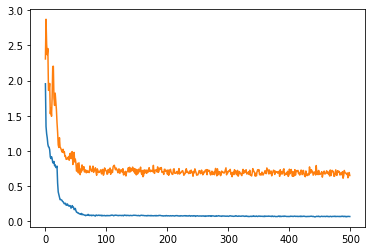

In [12]:
#코드작성
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(valid_loss)

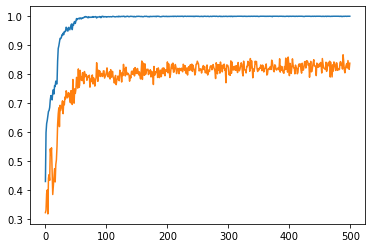

In [13]:
plt.plot(train_acc)
plt.plot(valid_acc)

* 최적의 모델 로드

In [14]:
# 학습된 모델 로드
model.load_state_dict(torch.load('model_useung.pt'))

<All keys matched successfully>

## Step 7: Predict with Test Data 

In [15]:
# test dataset 이미지 불러오기 위한 클래스
class test_dataset(Dataset):
    def __init__(self,imgpath,transform=None):
        
        self.imgpath = imgpath
        self.transform = transform
        
    def __len__(self):
        return len(self.imgpath)
    
    def __getitem__(self,idx):
        x = self.transform(Image.open(self.imgpath[idx]).convert('RGB'))
        
        return x

In [16]:
# test data의 transform 적용
test_transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

### test dataset과 dataloader 생성

In [17]:
# test 경로를 통해 불러오기
test_set = sorted(glob.glob('./imgs/test/*'))

test_data = test_dataset(test_set,test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, num_workers=0)

### Predict 수행

In [18]:
import numpy as np

# 예측값과 최종 예측 결과를 저장하기 위해 빈 배열 생성
pred= []
result = []

# 예측 시작을 알리는 출력문
print("Start Predict...\n\n")
for data in tqdm(test_loader): 
    # move tensors to GPU if CUDA is available
    data = data.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    # 예측된 결과 값을 연산하기 위한 forward 진행
    logits = model(data)
    # 예측된 결과 값 (logits)를 softmax 함수를 통해 총합이 1이 되는 0~1 사이의 값으로 pred 저장
    pred = logits.softmax(1)
    # 저장된 pred 값 중에 가장 높은 값 prediction 저장
    prediction = torch.argmax(pred, dim=1)
    # 예측 값을 리스트로 변환하여 result에 저장
    result += prediction.detach().cpu().tolist()


# 결과 값 길이 출력 확인
print(len(result))
# 결과 출력
print(result)

# 예측 완료 출력문
print("\n\n...Finish!")

Start Predict...




  0%|          | 0/5 [00:00<?, ?it/s]

604
[9, 8, 9, 13, 10, 11, 9, 3, 5, 6, 13, 9, 1, 8, 11, 14, 6, 9, 2, 1, 7, 3, 1, 11, 3, 7, 1, 6, 3, 9, 7, 3, 9, 4, 5, 14, 13, 11, 1, 9, 0, 0, 13, 9, 5, 12, 7, 5, 11, 2, 6, 2, 12, 2, 5, 14, 7, 3, 12, 12, 6, 1, 13, 13, 14, 5, 11, 7, 12, 3, 3, 12, 9, 3, 7, 1, 7, 5, 0, 4, 4, 3, 13, 4, 2, 14, 8, 1, 14, 0, 13, 11, 13, 5, 2, 3, 11, 0, 12, 1, 9, 0, 11, 1, 10, 10, 14, 12, 5, 12, 9, 4, 11, 3, 7, 12, 5, 14, 8, 4, 9, 7, 1, 4, 9, 9, 13, 6, 4, 4, 11, 10, 11, 14, 7, 1, 6, 3, 1, 7, 2, 7, 8, 3, 12, 6, 7, 2, 4, 3, 13, 13, 6, 7, 1, 11, 13, 2, 0, 7, 8, 2, 7, 1, 10, 0, 0, 0, 0, 3, 4, 7, 5, 2, 14, 3, 5, 2, 4, 1, 3, 14, 11, 6, 5, 4, 5, 12, 14, 11, 12, 4, 9, 4, 11, 10, 8, 14, 14, 3, 3, 3, 11, 6, 2, 11, 9, 4, 12, 6, 0, 8, 14, 10, 12, 2, 4, 5, 7, 1, 12, 7, 8, 12, 10, 3, 8, 4, 1, 11, 4, 6, 4, 3, 0, 7, 0, 7, 5, 14, 11, 9, 14, 5, 9, 6, 10, 8, 1, 10, 10, 0, 2, 11, 5, 1, 13, 11, 4, 3, 0, 12, 7, 0, 1, 4, 0, 2, 9, 7, 2, 11, 8, 10, 4, 3, 4, 2, 2, 4, 10, 11, 12, 4, 8, 14, 5, 10, 10, 2, 4, 6, 5, 3, 0, 0, 5, 10, 0, 4, 1, 1

예측 결과 인덱스를 저장한 pred 값을 사용해 클래스를 매칭하기 위한 class_name을 담아 놓은 리스트입니다.

주의할 점은 Train과정에서 사용된 class lable값과 같은 순서로 저장이 되어 있어야 한다는 점입니다

In [19]:
# class 명 출력 확인
class_names = train_data.classes
print(class_names)

['AMERICAN_PIPIT', 'BALTIMORE_ORIOLE', 'BELTED_KINGFISHER', 'BROWN_THRASHER', 'CALIFORNIA_GULL', 'CASPIAN_TERN', 'CRESTED_AUKLET', 'DOWNY_WOODPECKER', 'GRAY_CATBIRD', 'HOODED_MERGANSER', 'INDIGO_BUNTING', 'PURPLE_FINCH', 'RED_HEADED_WOODPECKER', 'RUBY_THROATED_HUMMINGBIRD', 'WHITE_NECKED_RAVEN']


In [20]:
# test 데이터의 이미지 id 와 예측한 class 라벨 값 category를 저장하기 위한 빈 배열 생성
id=[]
category =[]

for i in range(len(test_set)):
    # 불러온 test id 추가
    id.append(test_set[i].split('\\')[-1])
    # result 결과 값을 class names 명으로 추가
    category.append(class_names[result[i]])
# 데이터 프레임을 활용하여 최종 submission csv 파일 저장
pd.DataFrame({'Id':id,'Category':category}).to_csv('useung_sub.csv',index=False)

# 저장 완료 문장 출력
print("Save Complete!")

Save Complete!


# Ensemble

In [68]:
from tqdm import tqdm_notebook
import numpy as np

# 예측값과 최종 예측 결과를 저장하기 위해 빈 배열 생성
result = []
total_pred = np.zeros((604, 15))
# 앙상블하고자 하는 모델 명 저장
name = ['model_useung_81','model_useung_83']
# 예측 값 저장을 위한 빈 배열 생성
pred0 = []
pred1 = []

print("Start Predict...\n\n")
for fold in range(2):
    # USNet 모델 불러옴
    model = USNet()
    # Cuda device로 이동
    model.to(device)
    # name을 통해 앙상블 모델을 하나씩 불러옴
    model.load_state_dict(torch.load('./ensemble/{}.pt'.format(name[fold])))     
    
    # 최종 예측을 위한 빈 배열 생성
    prediction = []
    for idx,data in tqdm_notebook(enumerate(test_loader)):
        # 배치사이즈 만큼 pred 담는 torch 배열 초기화
        pred = torch.zeros((test_loader.batch_size, 15)).to(device)
        # move tensors to GPU if CUDA is available
        data = data.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        # 예측된 결과 값을 연산하기 위한 forward 진행
        logits = model(data)
        # 예측된 결과 값 (logits)를 softmax 함수를 통해 총합이 1이 되는 0~1 사이의 값으로 pred 저장
        pred = logits.softmax(1)
        # 예측 값을  numpy로 변환하여 prediction에 추가
        prediction.append(pred.detach().cpu())
    
    # 배치 단위로 저장된 prediction을 합침
    prediction = torch.cat(prediction)
    
    # fold가 0번째일 때, pred0에 prediction 저장
    if fold == 0:
        pred0 = prediction
    # fold가 2번째일 때, pred1에 prediction 저장
    elif fold == 1:
        pred1 = prediction


# 저장된 pred값을 평균내어 가장 높은 값 result에 저장
result = np.argmax((pred0+pred1)/2, axis=1)

# 결과 값 길이 출력 확인
print(len(result))
# 결과 출력
print(result)

# 예측 완료 출력문
print("\n\n...Finish!")

Start Predict...




<ipython-input-68-0db5dfdcec97>:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx,data in tqdm_notebook(enumerate(test_loader)):


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

604
tensor([ 9,  8,  9, 13, 13, 11, 14,  3,  5,  6, 13,  7,  1,  8, 11, 14,  6,  9,
         2,  1,  7,  8,  8, 11,  0,  7,  1,  6,  4,  9,  7,  3, 14,  4,  5, 14,
        13, 11,  1, 14,  0,  0, 13,  9,  5, 12,  7,  5, 11,  2,  6,  2, 12,  2,
         4,  4,  7,  3, 12, 12,  6,  1, 13, 13, 14,  5, 11,  7, 12,  3,  3, 12,
         9,  2,  7,  1,  7,  5, 14,  4,  4,  3, 13,  5,  2, 14, 13,  1, 14,  0,
        13, 11, 13,  5,  2,  8, 11,  0, 12,  1,  9,  0, 11,  1, 10, 10, 14, 12,
         5, 12,  9,  4, 11,  0,  7, 12,  5, 14,  8,  2,  9,  7,  1,  2,  9,  9,
        13,  6,  4,  4, 11, 10, 11, 14,  7,  1,  6,  3,  1, 14,  2,  7,  8,  3,
        12,  6,  7,  2,  4,  3, 13, 13,  6,  7,  1, 11, 13,  2,  0,  7,  8,  2,
         7,  1, 10,  0,  0,  8,  0,  3,  4,  7,  5,  2, 14,  0,  5,  2,  4,  1,
         3, 14, 11,  6,  5, 14,  5, 12, 14, 11, 12,  4,  9,  4, 11, 10,  8, 14,
        13,  3,  8,  3, 11,  6,  2, 11,  9,  9, 12,  6,  0,  8, 14, 10, 12,  2,
         4,  5,  7,  1, 12,  7,  8, 

In [69]:
# class 명 출력 확인
class_names = train_data.classes
print(class_names)

['AMERICAN_PIPIT', 'BALTIMORE_ORIOLE', 'BELTED_KINGFISHER', 'BROWN_THRASHER', 'CALIFORNIA_GULL', 'CASPIAN_TERN', 'CRESTED_AUKLET', 'DOWNY_WOODPECKER', 'GRAY_CATBIRD', 'HOODED_MERGANSER', 'INDIGO_BUNTING', 'PURPLE_FINCH', 'RED_HEADED_WOODPECKER', 'RUBY_THROATED_HUMMINGBIRD', 'WHITE_NECKED_RAVEN']


In [70]:
# test 데이터의 이미지 id 와 예측한 class 라벨 값 category를 저장하기 위한 빈 배열 생성
id=[]
category =[]
for i in range(len(test_set)):
    # 불러온 test id 추가
    id.append(test_set[i].split('\\')[-1])
    # result 결과 값을 class names 명으로 추가
    category.append(class_names[result[i]])
# 데이터 프레임을 활용하여 최종 submission csv 파일 저장
pd.DataFrame({'Id':id,'Category':category}).to_csv('useung_sub_ensemble.csv',index=False)

# 저장 완료 문장 출력
print("Save Complete!")

Save Complete!
